In [166]:
import pandas as pd
import numpy as np
import h5py
from sklearn.metrics import f1_score


In [167]:
# read all freeze_frame data set 

freeze_frame = pd.read_csv('freeze_frame_index_all.csv')


ptsd_data = pd.read_csv('/Users/novak/Documents/Columbia/mentored_research/Turi/Analysis/PTSD_filtered.csv')
ptsd_data = ptsd_data[['cohort_id', 'condition']].drop_duplicates()

freeze_frame = freeze_frame.merge(ptsd_data, on='cohort_id', how='left')
freeze_frame_175_bouts = freeze_frame[freeze_frame['bouts'] == 1.75]


In [168]:
# read in moseq data from h5 file 
file_path = '/Users/novak/Downloads/moseq_results_1204.h5'

all_data = []

with h5py.File(file_path, 'r') as hdf:
    for group_name in hdf.keys():
        group_data = hdf[group_name]
        
        centroid = group_data['centroid'][:]
        heading = group_data['heading'][:]
        latent_state = group_data['latent_state'][:]
        syllable = group_data['syllable'][:]
        
        df = pd.DataFrame({
            'centroid_x': centroid[:, 0],
            'centroid_y': centroid[:, 1],
            'heading': heading,
            'syllable': syllable
        })
        
        latent_df = pd.DataFrame(latent_state, columns=[f'latent_{i}' for i in range(latent_state.shape[1])])
        df = pd.concat([df, latent_df], axis=1)
        
        df['cohort_id'] = group_name
        
        all_data.append(df)

moseq_data = pd.concat(all_data, ignore_index=True)
freeze_syllable = [0, 2, 4, 9, 12, 18, 22]
moseq_data['moseq_freeze'] = [1 if x in freeze_syllable else 0 for x in moseq_data['syllable']]
moseq_data.head()

,centroid_x,centroid_y,heading,syllable,latent_0,latent_1,latent_2,latent_3,latent_4,cohort_id,moseq_freeze
0,157.170182,90.121150,-1.534691,19,-2.896828,0.296252,-3.028007,-0.669359,0.157965,ptsd2_recall1_81DLC_resnet50_phi_cfc_boxNov7sh...,0
1,157.646806,89.821706,-2.666358,19,1.616781,-4.008245,1.684066,8.429051,0.367887,ptsd2_recall1_81DLC_resnet50_phi_cfc_boxNov7sh...,0
2,158.585059,93.169466,0.545328,19,-1.317866,14.201049,0.393275,3.799482,-1.431989,ptsd2_recall1_81DLC_resnet50_phi_cfc_boxNov7sh...,0
3,156.452917,94.057004,-1.070421,19,3.814071,-3.309042,-3.452236,30.185059,12.433039,ptsd2_recall1_81DLC_resnet50_phi_cfc_boxNov7sh...,0
4,155.292240,95.179872,0.939291,19,-1.112701,3.940877,2.324993,-18.466029,-8.148632,ptsd2_recall1_81DLC_resnet50_phi_cfc_boxNov7sh...,0


In [169]:
def plot_freeze_ethogram(freeze_df, moseq_df, freeze_col='freeze', moseq_col='moseq_freeze', 
                     freeze_label='FreezeFrame', moseq_label='KPMS'):
    """
    Plots an ethogram comparing freeze and moving states between two models with a normalized time axis.
    Uses softer colors and adds dark outlines between each row for clarity.
    
    Parameters:
    - freeze_df: DataFrame containing the FreezeFrame data.
    - moseq_df: DataFrame containing the KPMS data.
    - freeze_col: Column name in freeze_df representing the freeze states (default is 'freeze').
    - moseq_col: Column name in moseq_df representing the freeze states (default is 'moseq_freeze').
    - freeze_label: Label for the FreezeFrame data (default is 'FreezeFrame').
    - moseq_label: Label for the KPMS data (default is 'KPMS').
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import f1_score

    freeze_len = len(freeze_df)
    moseq_len = len(moseq_df)

    # Align lengths of freeze and moseq data
    min_length = min(freeze_len, moseq_len)
    freeze_states = freeze_df[freeze_col].iloc[:min_length]
    moseq_states = moseq_df[moseq_col].iloc[:min_length]

    # Calculate F1 score
    try:
        f1 = f1_score(freeze_states, moseq_states, average='binary')
    except ValueError as e:
        print(f"Error calculating F1 score: {e}")
        f1 = 0.0

    # Create percentage-based x-axis instead of absolute number of frames 
    freeze_percentage = (freeze_df.index / freeze_len) * 300
    moseq_percentage = (moseq_df.index / moseq_len) * 300

    fig, ax = plt.subplots(figsize=(10, 4))

    moving_color = "#F08080"  
    freeze_color = "#4682B4"  

    # Plot FreezeFrame data
    ax.fill_between(freeze_percentage, 0, 1, color=moving_color, alpha=0.5)
    ax.fill_between(freeze_percentage, 0, 1, where=(freeze_df[freeze_col] == 1), 
                    step='post', color=freeze_color, alpha=0.8)

    # Plot KPMS data
    ax.fill_between(moseq_percentage, 1, 2, color=moving_color, alpha=0.5)
    ax.fill_between(moseq_percentage, 1, 2, where=(moseq_df[moseq_col] == 1), 
                    step='post', color=freeze_color, alpha=0.8)

    # Add black outlines for each row
    for y in [0, 1, 1, 2]:
        ax.plot([0, 300], [y, y], color='black', linewidth=1.5)


    cohort_id = freeze_df['cohort_id'].iloc[0]
    day = freeze_df['day'].iloc[0]

    # Set labels and titles
    ax.set_yticks([0.45, 1.55])
    ax.set_yticklabels([freeze_label, moseq_label])
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Ethogram {cohort_id} {day}: {freeze_label} vs {moseq_label} (F1 Score: {f1:.2f})")

    plt.tight_layout()
    plt.show()


In [170]:
def plot_syllable_ethogram(freeze_df, moseq_df, freeze_col='freeze', syllable_col='syllable', 
                           freeze_label='FreezeFrame', moseq_label='KPMS'):
    """
    Plots an ethogram comparing freeze states from FreezeFrame with all syllables in KPMS data.
    Uses different colors for each syllable and includes a legend for clarity.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.cm import tab20

    # Check for empty subsets
    if freeze_df.empty or moseq_df.empty:
        print("Either freeze_df or moseq_df is empty. Skipping plot.")
        return

    freeze_len = len(freeze_df)
    moseq_len = len(moseq_df)

    # Align lengths of freeze and moseq data
    min_length = min(freeze_len, moseq_len)
    freeze_states = freeze_df[freeze_col].iloc[:min_length]
    syllables = moseq_df[syllable_col].iloc[:min_length]

    # Debugging: Print unique syllables
    print(f"Unique syllables for cohort: {syllables.unique()}")

    # Create percentage-based x-axis using min_length
    freeze_percentage = (np.arange(min_length) / min_length) * 300
    moseq_percentage = (np.arange(min_length) / min_length) * 300

    # Get unique syllables and assign colors
    unique_syllables = syllables.unique()
    colors = {syllable: color for syllable, color in zip(unique_syllables, tab20.colors[:len(unique_syllables)])}

    fig, ax = plt.subplots(figsize=(10, 6))

    moving_color = "#F08080"  # Color for movement
    freeze_color = "#4682B4"  # Color for freezing
    default_color = "#808080"  # Fallback color for unexpected syllables

    # Plot FreezeFrame data
    ax.fill_between(freeze_percentage, 0, 1, color=moving_color, alpha=0.5, label='Movement')
    ax.fill_between(freeze_percentage, 0, 1, where=(freeze_states == 1), 
                    step='post', color=freeze_color, alpha=0.8, label='Freeze')

    # Plot KPMS syllables
    for syllable in unique_syllables:
        syllable_mask = (syllables == syllable)
        ax.fill_between(moseq_percentage, 1, 2, where=syllable_mask, 
                        step='post', color=colors.get(syllable, default_color), alpha=0.8, label=f"Syllable {syllable}")

    # Add black outlines for each row
    for y in [0, 1, 1, 2]:
        ax.plot([0, 300], [y, y], color='black', linewidth=1.5)

    cohort_id = freeze_df['cohort_id'].iloc[0]
    day = freeze_df['day'].iloc[0]

    # Set labels and titles
    ax.set_yticks([0.45, 1.55])
    ax.set_yticklabels([freeze_label, moseq_label])
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Ethogram {cohort_id} {day}: {freeze_label} vs {moseq_label}")

    # Add legend
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize='small')

    plt.tight_layout()
    plt.show()


In [171]:
import re

def extract_cohort_and_day(file_name):
    """Extracts cohort_id and day from the cohort_id column in moseq_data."""
    match1 = re.match(r'(\w+)_([a-zA-Z]+\d*)_(\d+)', file_name)  # Format 1
    match2 = re.match(r'(\w+)_([a-zA-Z]+\d*)_(\d+)-(\d+)', file_name)  # Format 2

    if match2:  # Format 2 (e.g., ptsd9 group with longer cohort_id)
        cohort_prefix = match2.group(1)
        day = match2.group(2)
        cohort_number1 = match2.group(3)
        cohort_number2 = match2.group(4)
        cohort_id = f"{cohort_prefix}_{cohort_number1}_{cohort_number2}"
    elif match1:  # Format 1 (standard format)
        cohort_prefix = match1.group(1)
        day = match1.group(2)
        cohort_number = match1.group(3)
        cohort_id = f"{cohort_prefix}_{cohort_number}"
    else:
        cohort_id = 'unknown'
        day = 'unknown'

    return cohort_id, day


In [172]:
def plot_all_ethograms(freeze_frame, moseq_data, plot_func):
    """
    Matches unique cohort IDs between freeze_frame and moseq_data datasets,
    reindexes freeze_frame data, and plots ethograms for all matched IDs.
    Tracks F1 scores for total, 'sefl', and 'control' conditions.

    Parameters:
    - freeze_frame: DataFrame containing the freeze frame data.
    - moseq_data: DataFrame containing the moseq data.
    - plot_func: Function to plot the ethograms (e.g., plot_ethogram_v6).
    """
    # Extract cohort_id and day for moseq_data
    moseq_data[['cohort_id', 'day']] = moseq_data['cohort_id'].apply(
        lambda x: pd.Series(extract_cohort_and_day(x))
    )

    # Match IDs between datasets
    matched_ids = moseq_data[['cohort_id', 'day']].drop_duplicates()

    # Initialize totals
    f1_total = 0.0
    f1_count = 0
    f1_scores_by_condition = {'sefl': [], 'control': []}

    # Loop through matched IDs and plot ethograms
    for _, row in matched_ids.iterrows():
        cohort_id, day = row['cohort_id'], row['day']

        # Filter data for the current ID
        freeze_subset = freeze_frame[(freeze_frame['cohort_id'] == cohort_id) & (freeze_frame['day'] == day)].copy()
        moseq_subset = moseq_data[(moseq_data['cohort_id'] == cohort_id) & (moseq_data['day'] == day)].copy()

        if freeze_subset.empty or moseq_subset.empty:
            print(f"Skipping plot for Cohort ID: {cohort_id}, Day: {day} due to empty data.")
            continue

        # Reindex freeze_frame and moseq_data
        freeze_subset.reset_index(drop=True, inplace=True)
        moseq_subset.reset_index(drop=True, inplace=True)

        # Plot using the provided function and capture F1 score
        try:
            plot_func(
                freeze_df=freeze_subset,
                moseq_df=moseq_subset,
                freeze_col='freeze',
                moseq_col='moseq_freeze',
                freeze_label='FreezeFrame',
                moseq_label='KPMS'
            )
            # Capture F1 score from plot function
            f1 = f1_score(
                freeze_subset['freeze'][:len(moseq_subset)],
                moseq_subset['moseq_freeze'][:len(freeze_subset)],
                average='binary'
            )
            f1_total += f1
            f1_count += 1

            # Determine condition and store the F1 score
            condition = freeze_subset['condition'].iloc[0]  # Assuming one condition per subset
            if condition in f1_scores_by_condition:
                f1_scores_by_condition[condition].append(f1)
            else:
                print(f"Unexpected condition: {condition}")

        except Exception as e:
            print(f"Error calculating F1 for Cohort ID: {cohort_id}, Day: {day}. Skipping. {e}")
            continue

        print(f"Plotted ethogram for Cohort ID: {cohort_id}, Day: {day}, F1 Score: {f1:.2f}")

    # Calculate averages for conditions
    print("\nF1 Scores Summary:")
    if f1_count > 0:
        print(f"Total F1 Score: {f1_total:.2f}")
        print(f"Average F1 Score (All): {f1_total / f1_count:.2f}")
    
    for condition, scores in f1_scores_by_condition.items():
        if scores:
            avg_f1 = sum(scores) / len(scores)
            print(f"Average F1 Score ({condition.capitalize()}): {avg_f1:.2f}")
        else:
            print(f"No F1 scores for condition: {condition.capitalize()}")


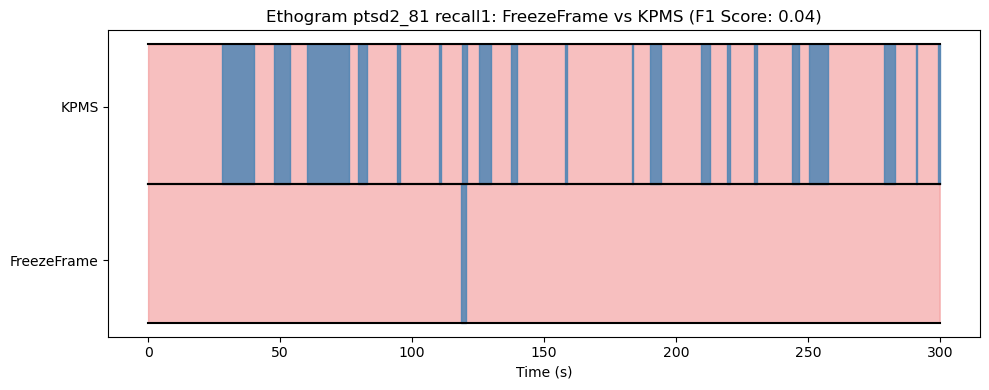

Plotted ethogram for Cohort ID: ptsd2_81, Day: recall1, F1 Score: 0.04


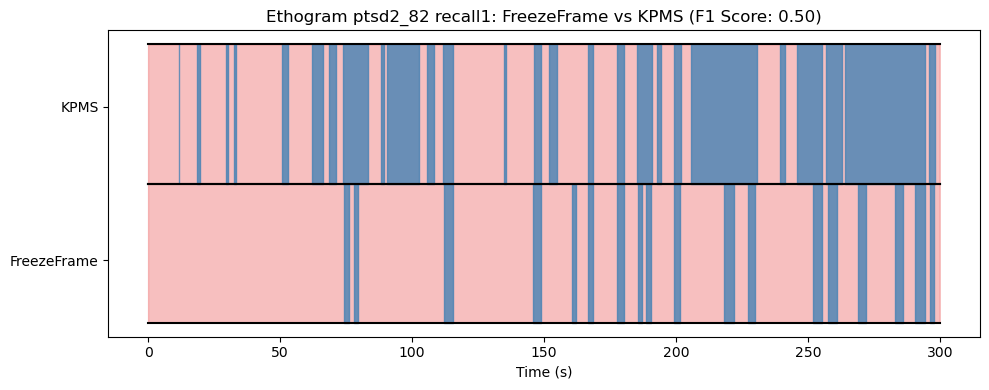

Plotted ethogram for Cohort ID: ptsd2_82, Day: recall1, F1 Score: 0.50


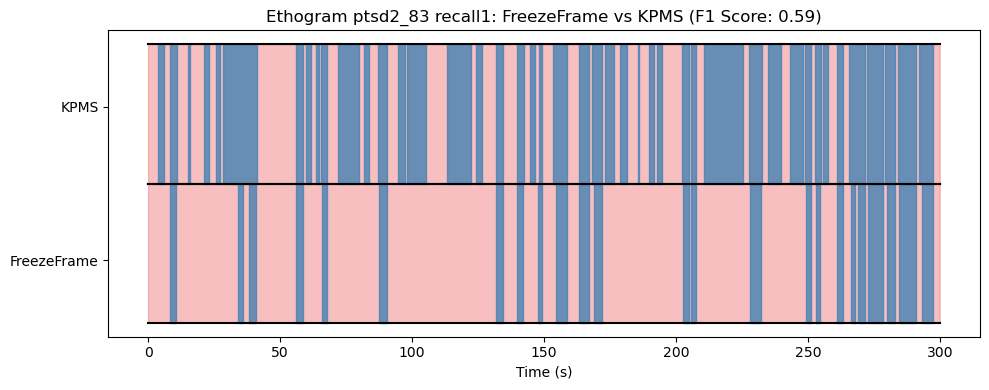

Plotted ethogram for Cohort ID: ptsd2_83, Day: recall1, F1 Score: 0.59


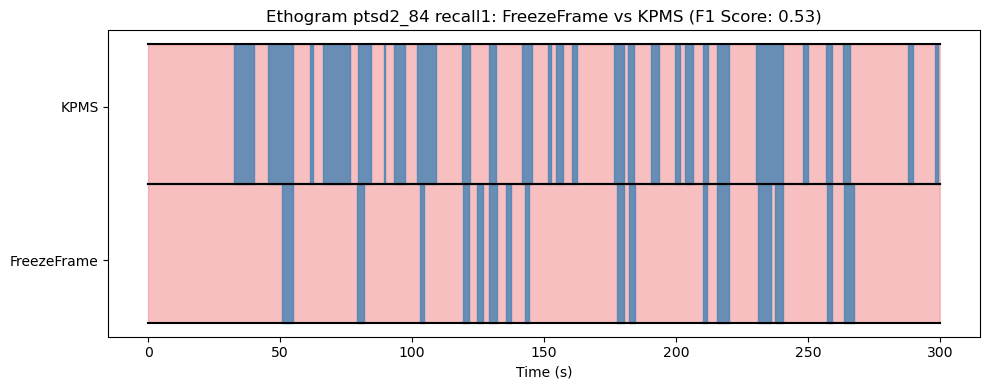

Plotted ethogram for Cohort ID: ptsd2_84, Day: recall1, F1 Score: 0.53


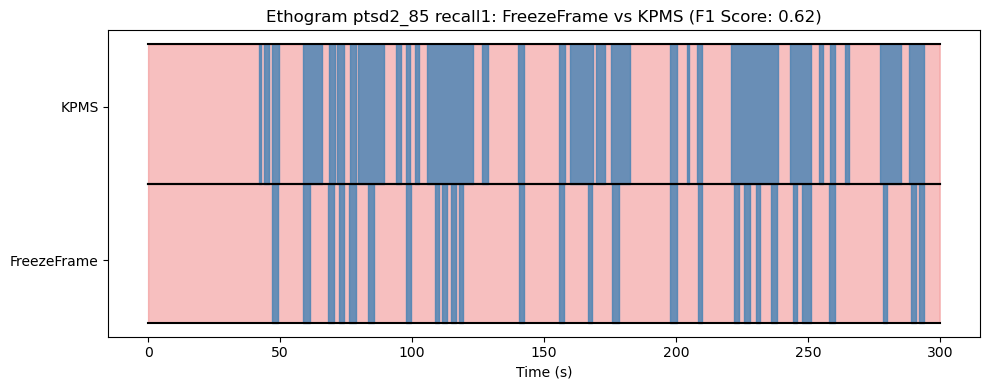

Plotted ethogram for Cohort ID: ptsd2_85, Day: recall1, F1 Score: 0.62


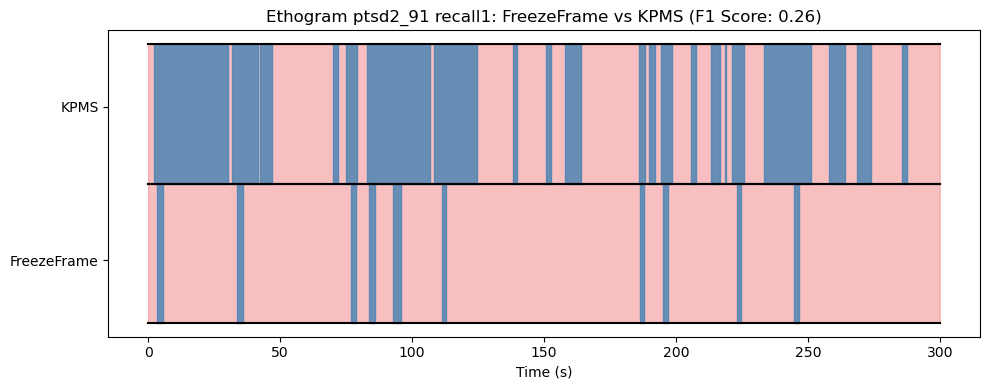

Plotted ethogram for Cohort ID: ptsd2_91, Day: recall1, F1 Score: 0.26


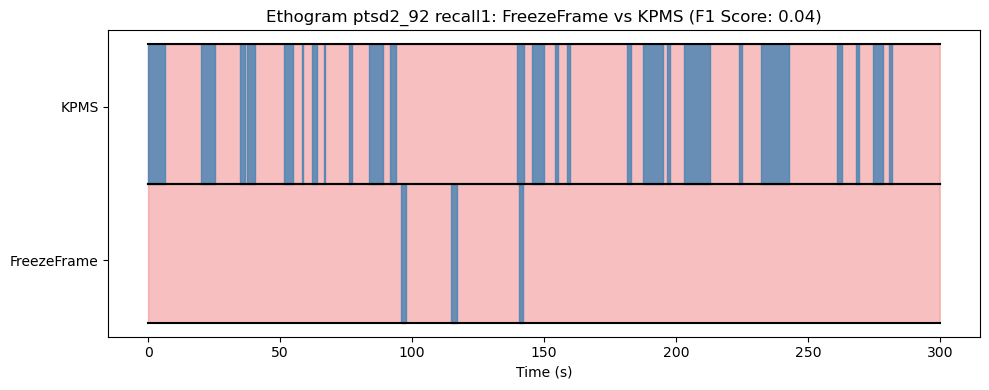

Plotted ethogram for Cohort ID: ptsd2_92, Day: recall1, F1 Score: 0.04


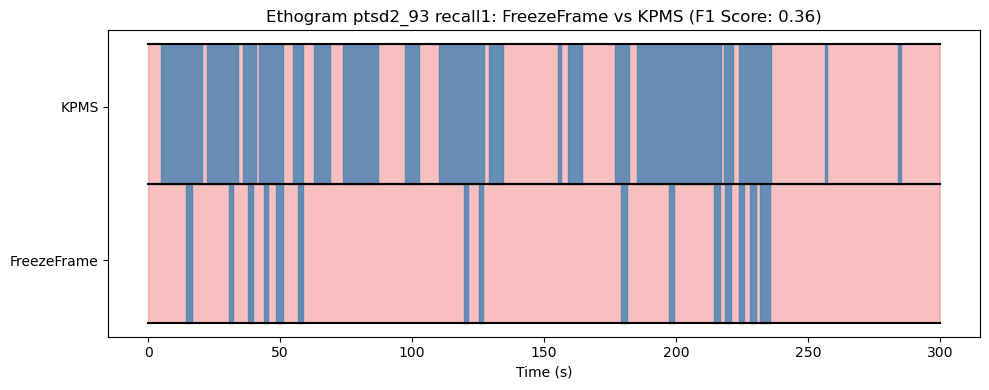

Plotted ethogram for Cohort ID: ptsd2_93, Day: recall1, F1 Score: 0.36


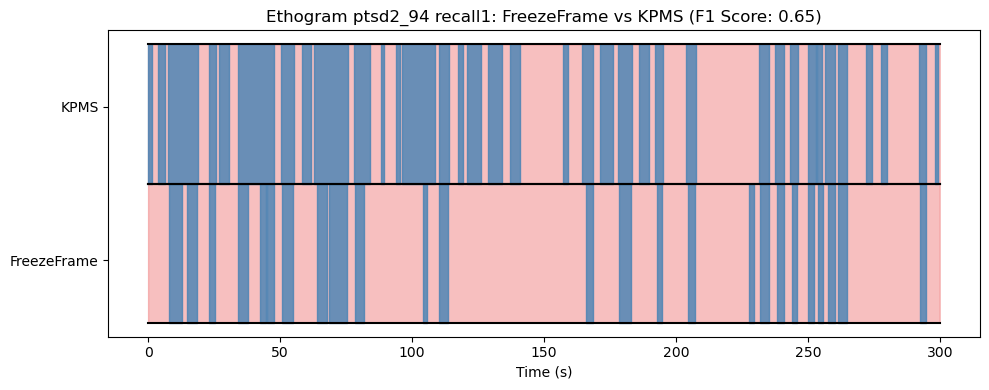

Plotted ethogram for Cohort ID: ptsd2_94, Day: recall1, F1 Score: 0.65


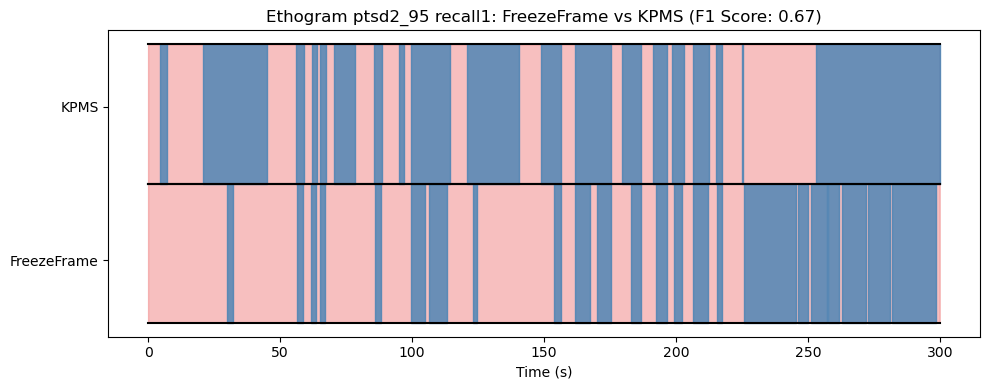

Plotted ethogram for Cohort ID: ptsd2_95, Day: recall1, F1 Score: 0.67


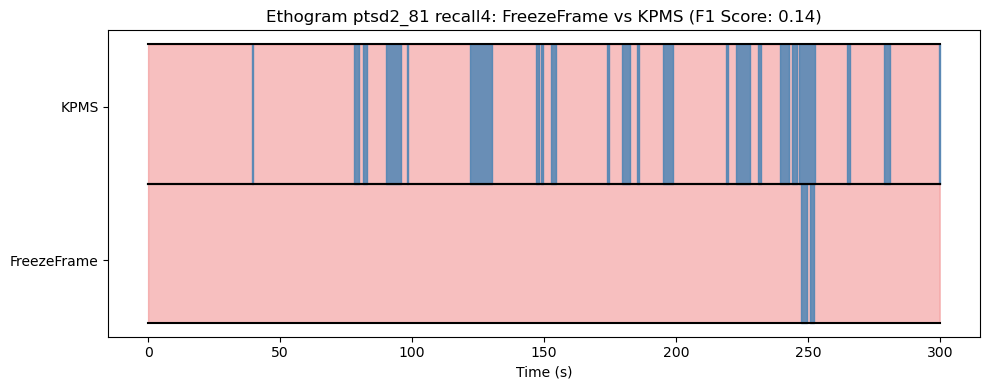

Plotted ethogram for Cohort ID: ptsd2_81, Day: recall4, F1 Score: 0.14


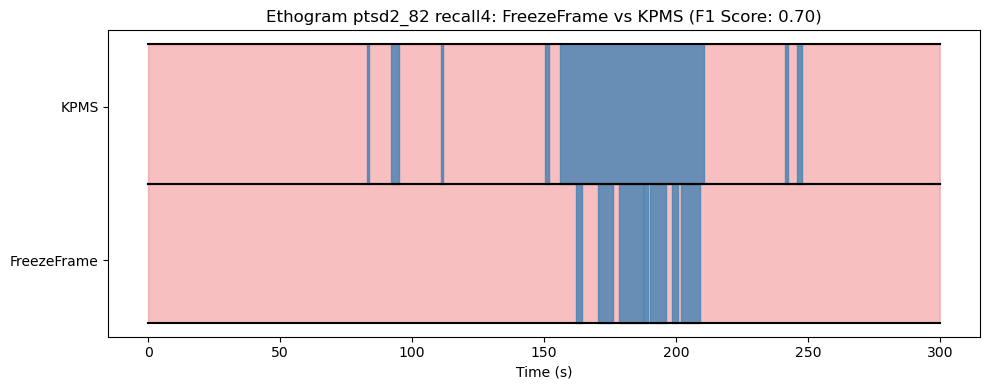

Plotted ethogram for Cohort ID: ptsd2_82, Day: recall4, F1 Score: 0.70


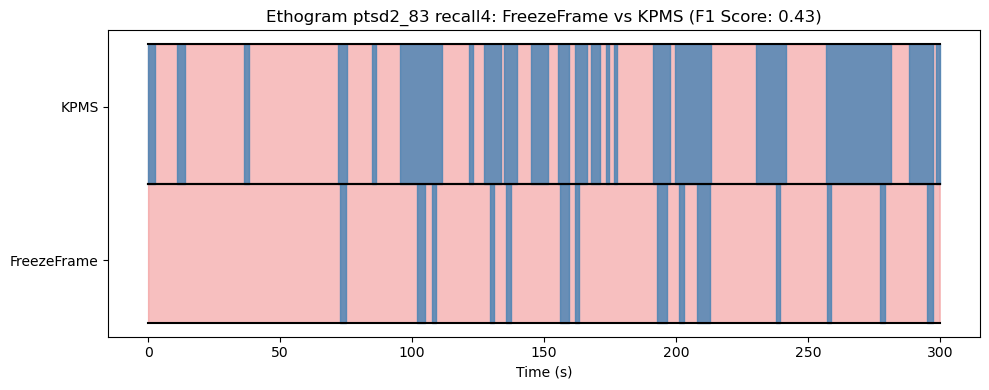

Plotted ethogram for Cohort ID: ptsd2_83, Day: recall4, F1 Score: 0.43


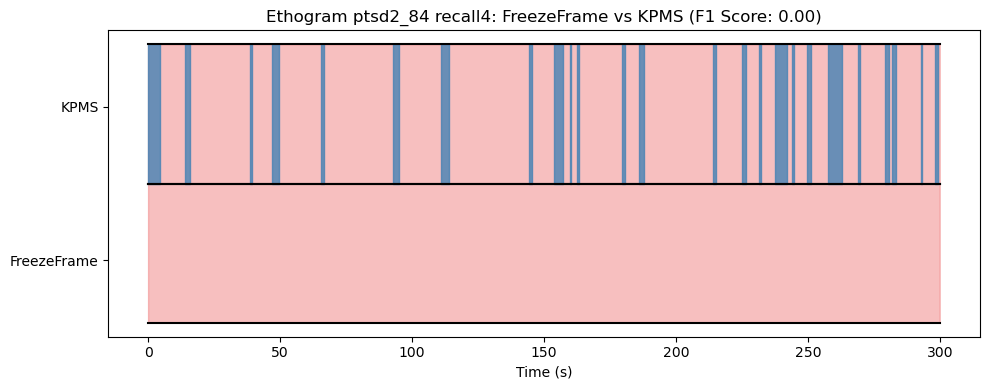

Plotted ethogram for Cohort ID: ptsd2_84, Day: recall4, F1 Score: 0.00


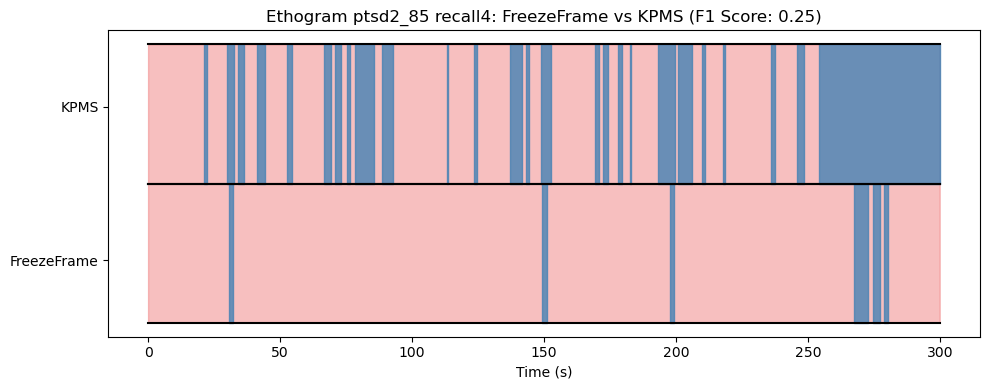

Plotted ethogram for Cohort ID: ptsd2_85, Day: recall4, F1 Score: 0.25


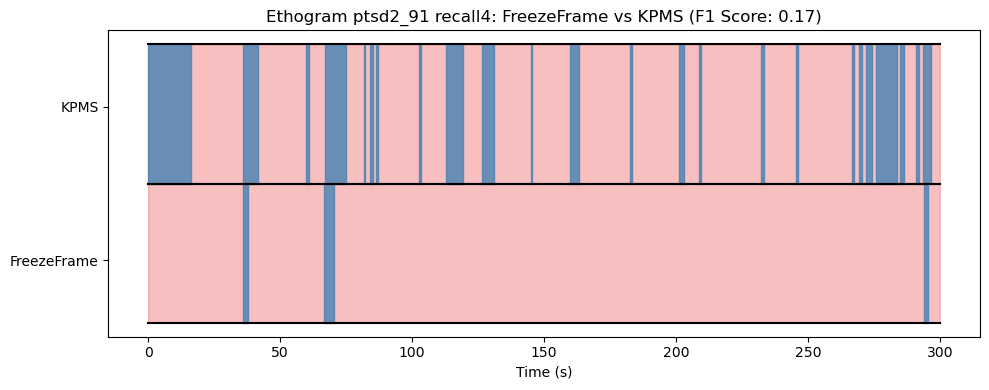

Plotted ethogram for Cohort ID: ptsd2_91, Day: recall4, F1 Score: 0.17


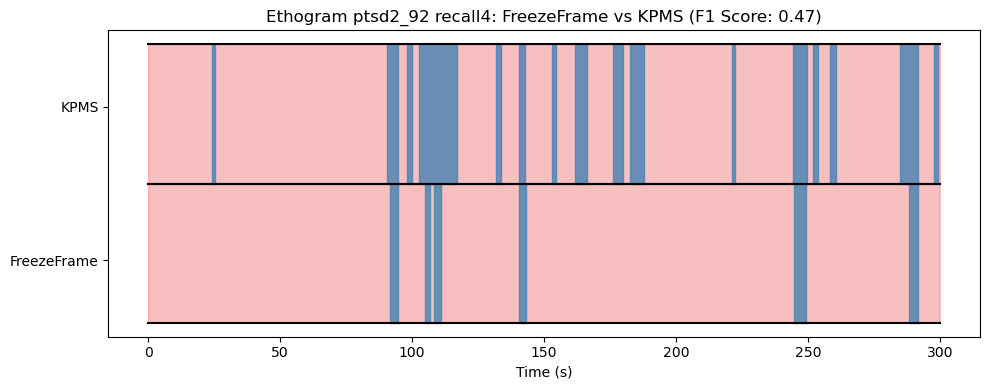

Plotted ethogram for Cohort ID: ptsd2_92, Day: recall4, F1 Score: 0.47


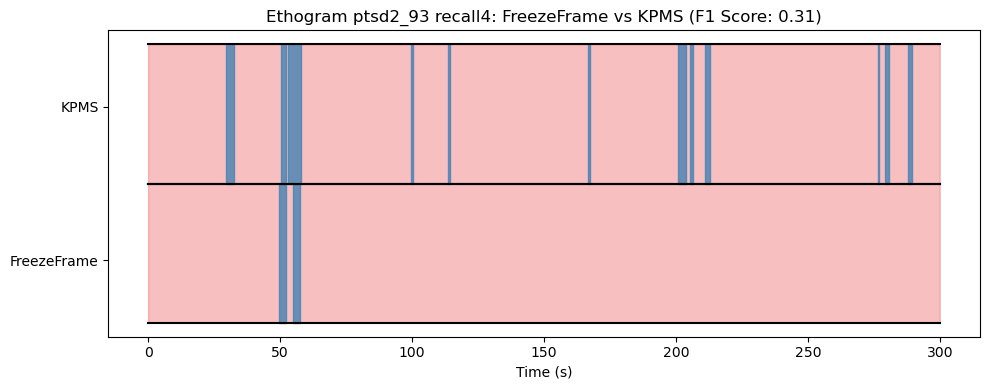

Plotted ethogram for Cohort ID: ptsd2_93, Day: recall4, F1 Score: 0.31


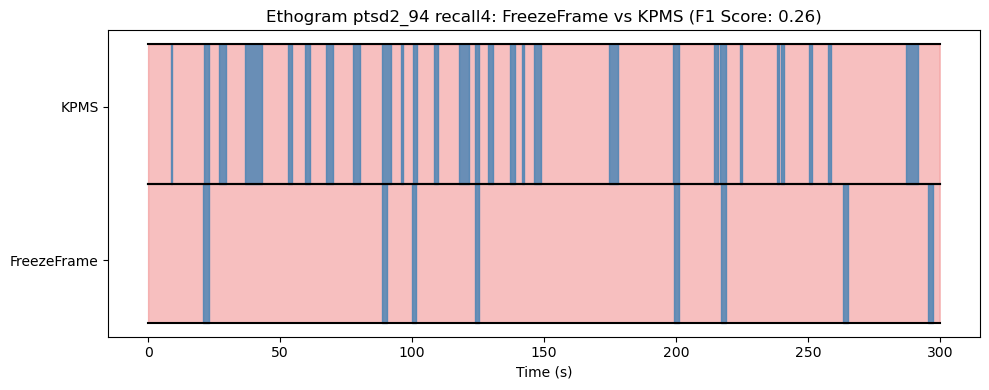

Plotted ethogram for Cohort ID: ptsd2_94, Day: recall4, F1 Score: 0.26


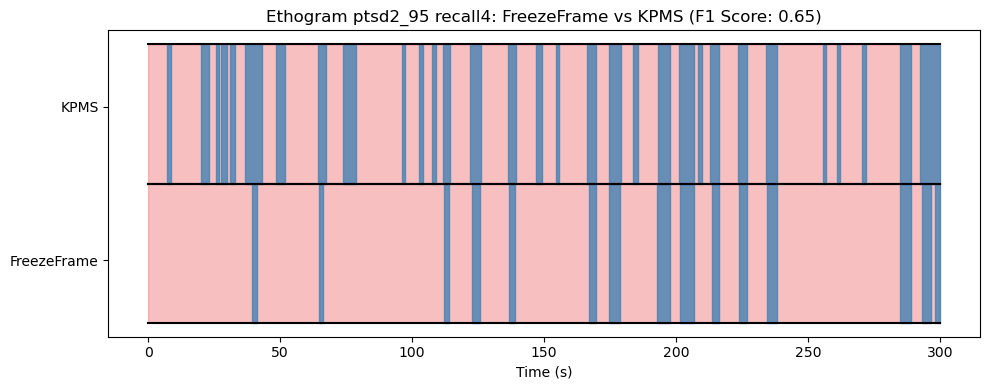

Plotted ethogram for Cohort ID: ptsd2_95, Day: recall4, F1 Score: 0.65


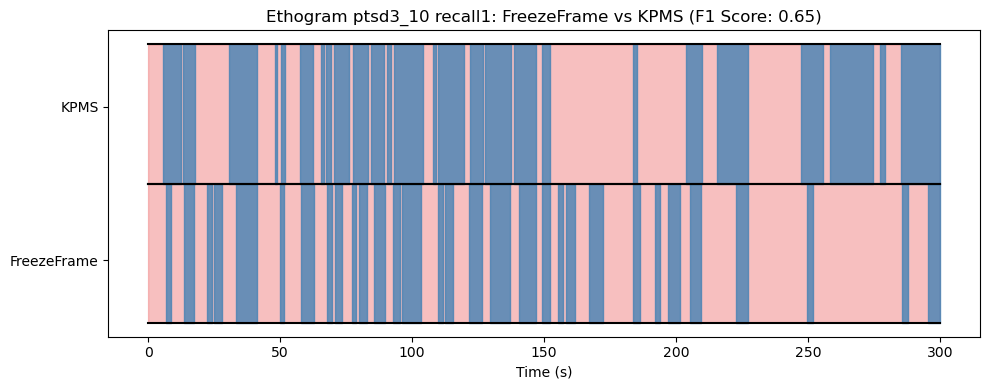

Plotted ethogram for Cohort ID: ptsd3_10, Day: recall1, F1 Score: 0.65


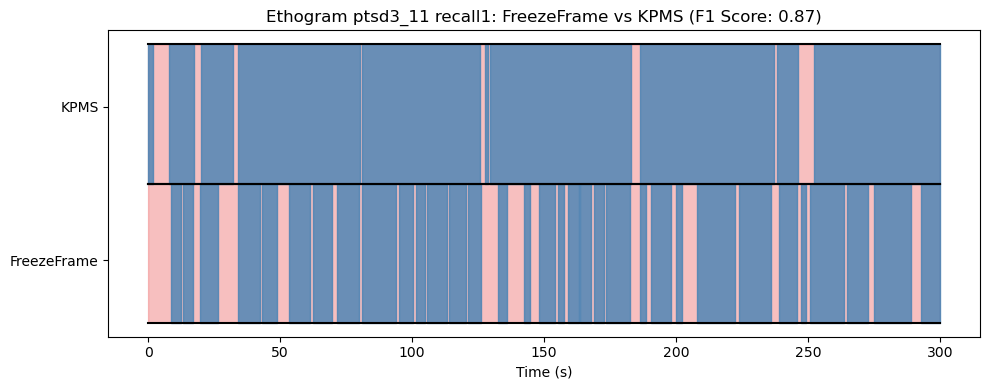

Plotted ethogram for Cohort ID: ptsd3_11, Day: recall1, F1 Score: 0.87


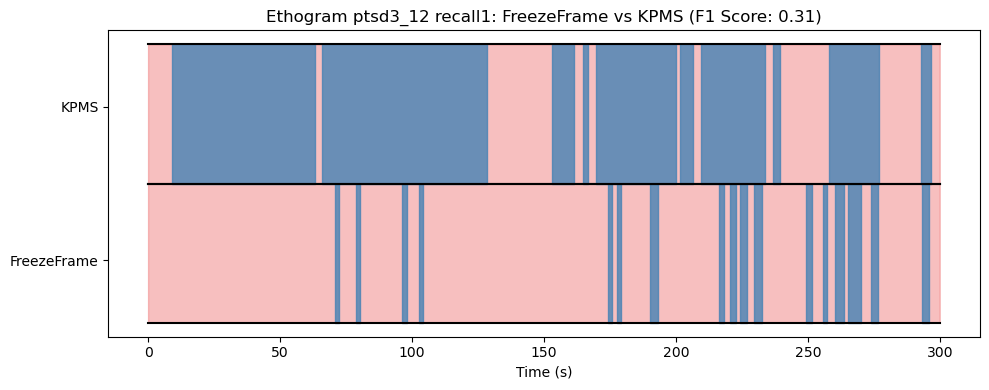

Plotted ethogram for Cohort ID: ptsd3_12, Day: recall1, F1 Score: 0.31


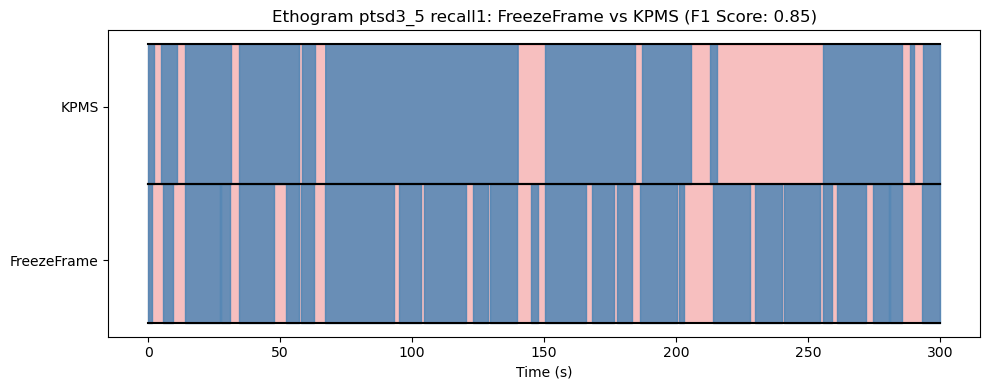

Plotted ethogram for Cohort ID: ptsd3_5, Day: recall1, F1 Score: 0.85


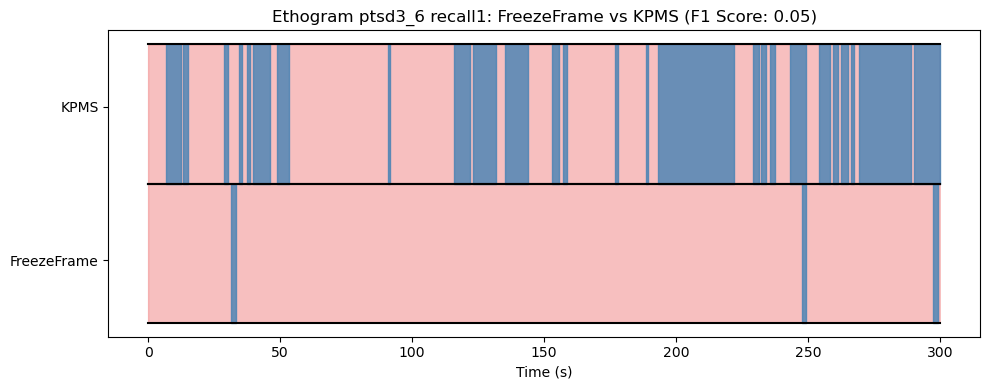

Plotted ethogram for Cohort ID: ptsd3_6, Day: recall1, F1 Score: 0.05


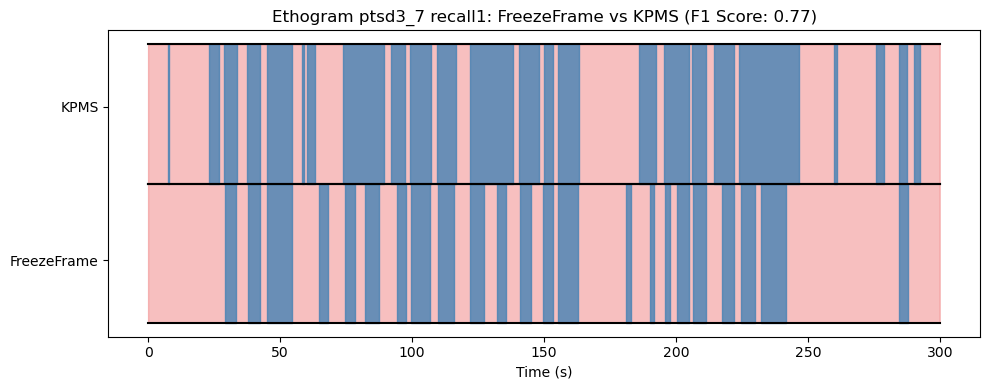

Plotted ethogram for Cohort ID: ptsd3_7, Day: recall1, F1 Score: 0.77


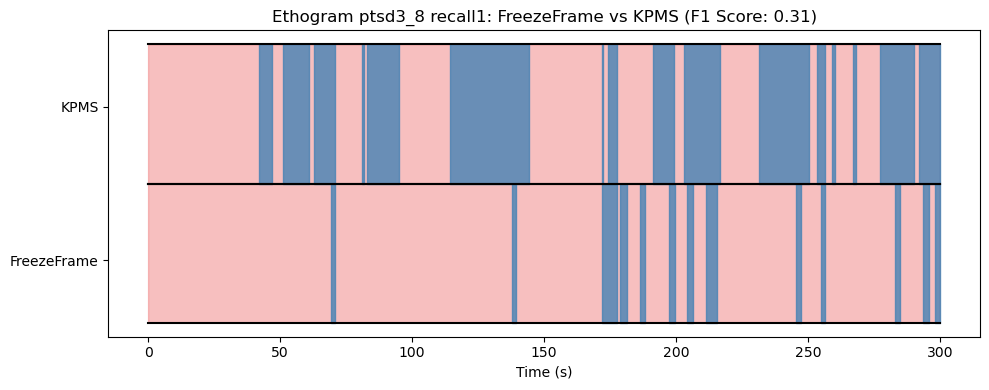

Plotted ethogram for Cohort ID: ptsd3_8, Day: recall1, F1 Score: 0.31


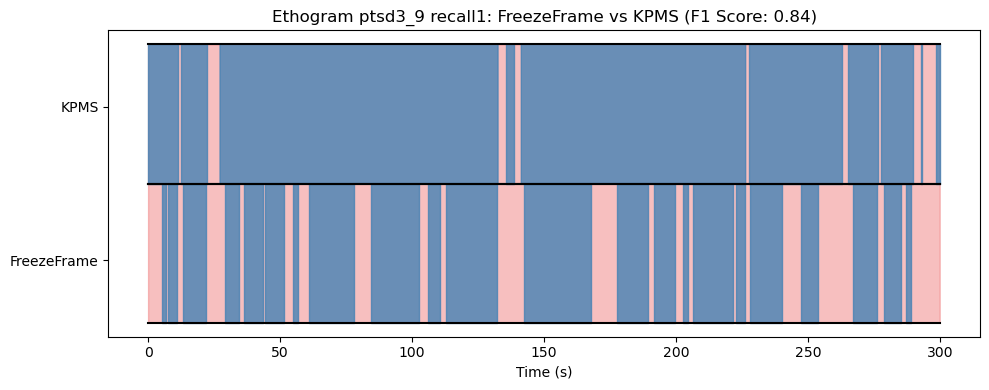

Plotted ethogram for Cohort ID: ptsd3_9, Day: recall1, F1 Score: 0.84


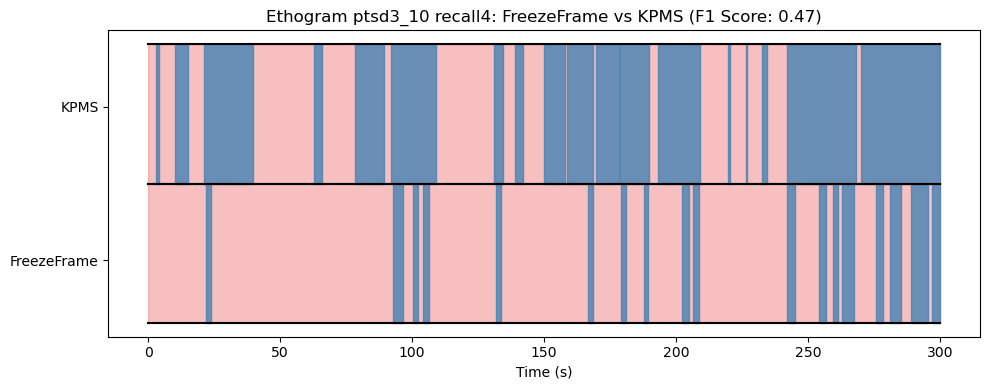

Plotted ethogram for Cohort ID: ptsd3_10, Day: recall4, F1 Score: 0.47


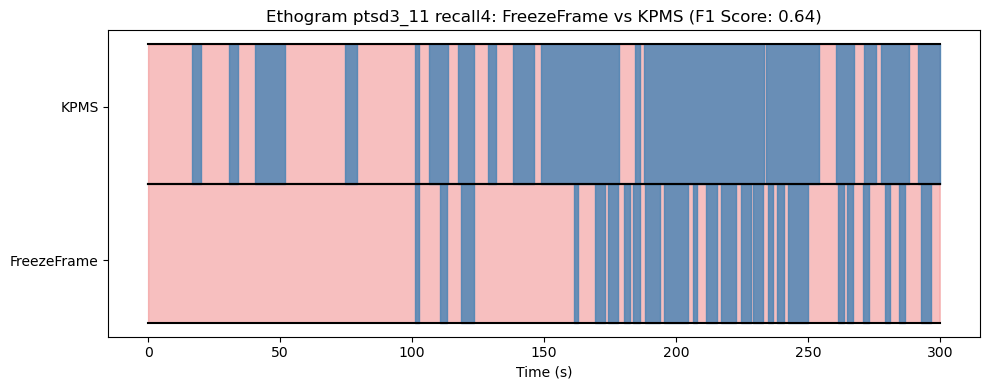

Plotted ethogram for Cohort ID: ptsd3_11, Day: recall4, F1 Score: 0.64


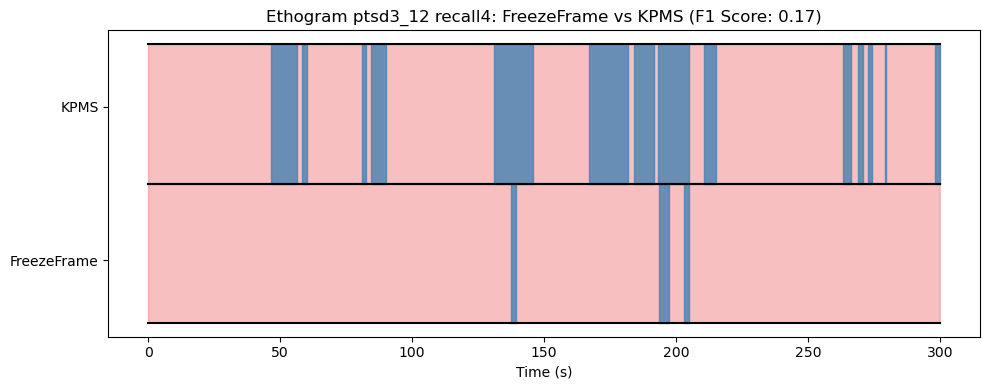

Plotted ethogram for Cohort ID: ptsd3_12, Day: recall4, F1 Score: 0.17


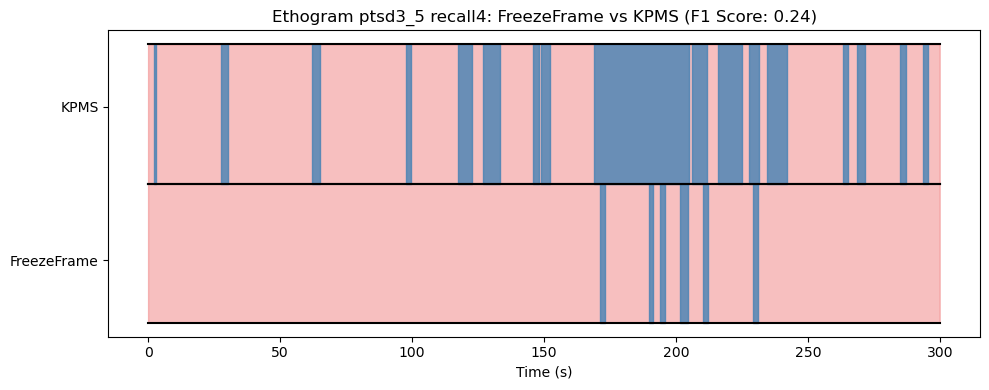

Plotted ethogram for Cohort ID: ptsd3_5, Day: recall4, F1 Score: 0.24


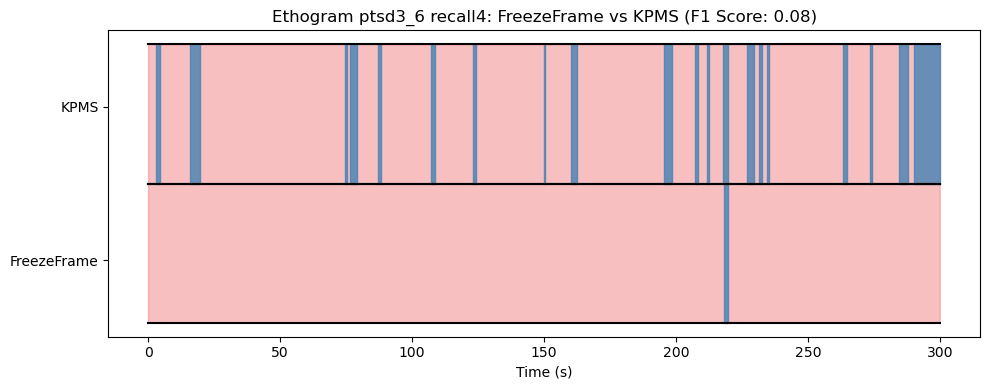

Plotted ethogram for Cohort ID: ptsd3_6, Day: recall4, F1 Score: 0.08


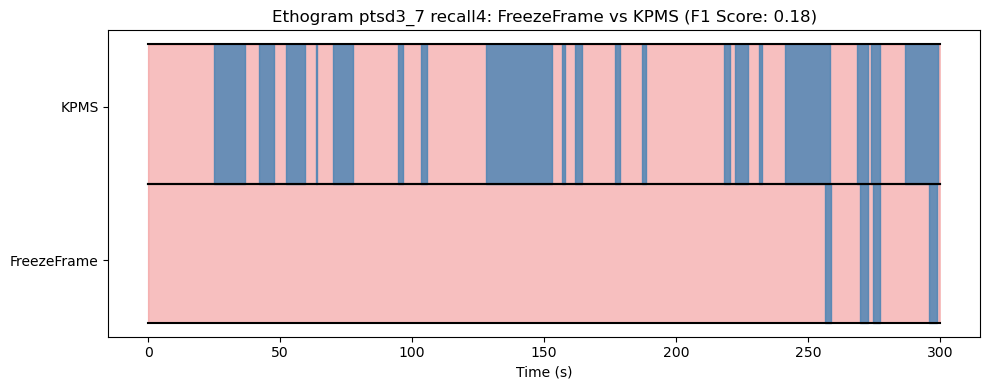

Plotted ethogram for Cohort ID: ptsd3_7, Day: recall4, F1 Score: 0.18


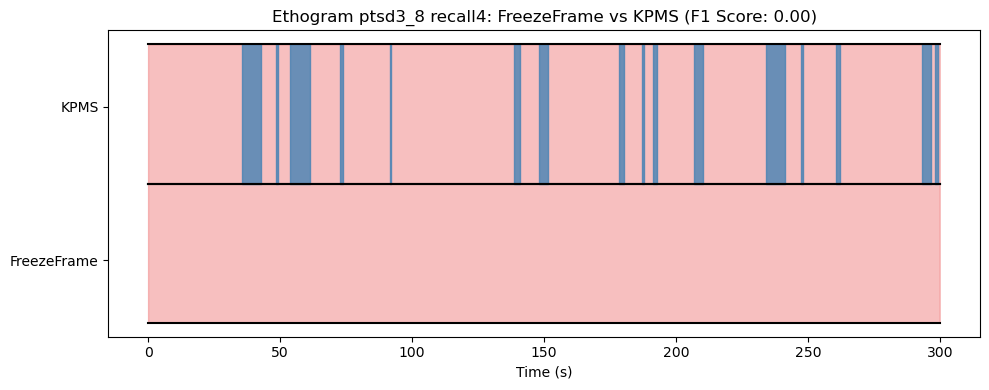

Plotted ethogram for Cohort ID: ptsd3_8, Day: recall4, F1 Score: 0.00


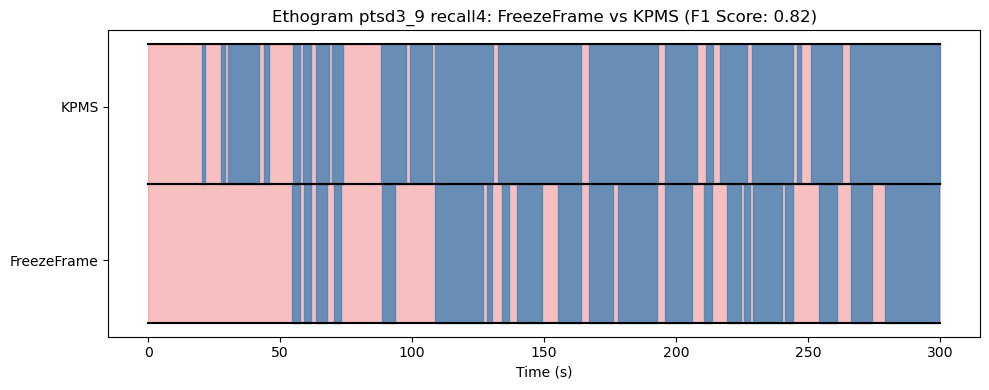

Plotted ethogram for Cohort ID: ptsd3_9, Day: recall4, F1 Score: 0.82


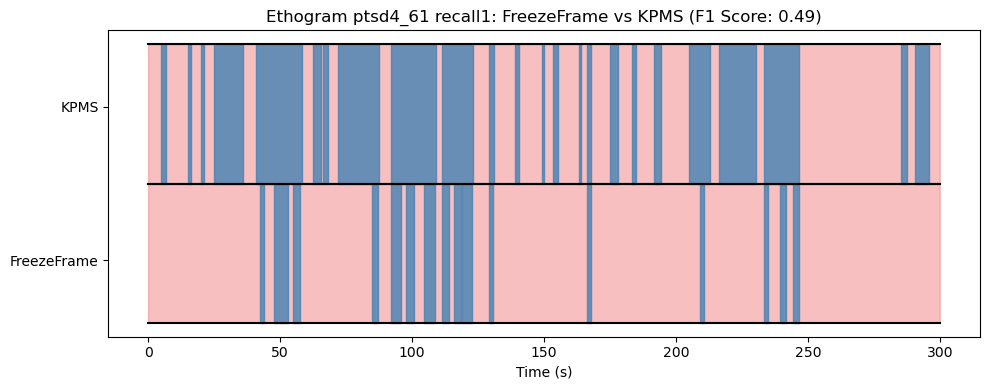

Plotted ethogram for Cohort ID: ptsd4_61, Day: recall1, F1 Score: 0.49


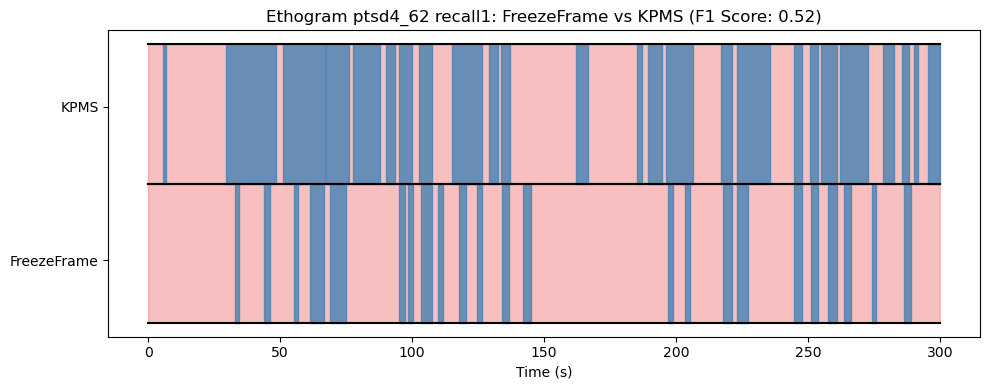

Plotted ethogram for Cohort ID: ptsd4_62, Day: recall1, F1 Score: 0.52


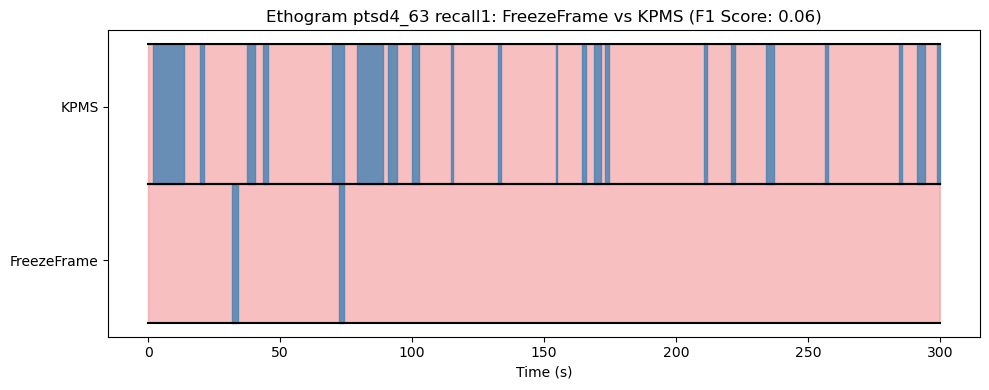

Plotted ethogram for Cohort ID: ptsd4_63, Day: recall1, F1 Score: 0.06


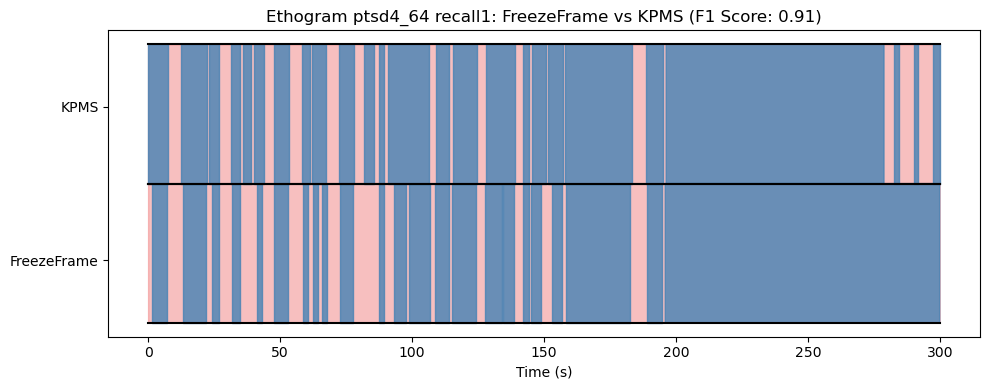

Plotted ethogram for Cohort ID: ptsd4_64, Day: recall1, F1 Score: 0.91


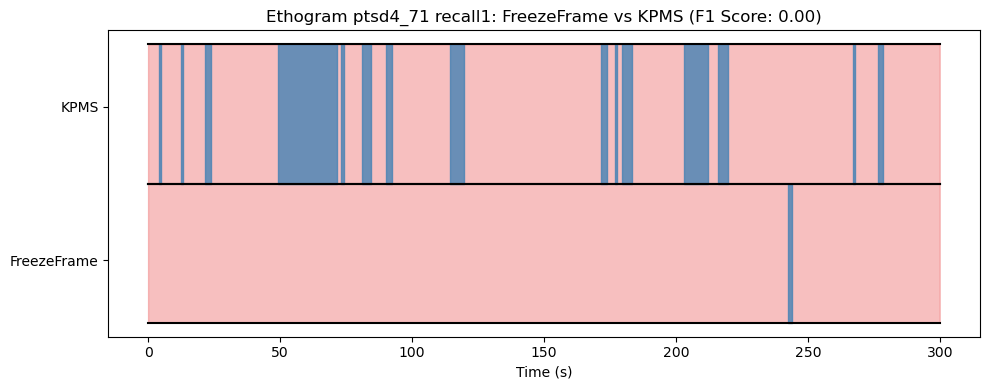

Plotted ethogram for Cohort ID: ptsd4_71, Day: recall1, F1 Score: 0.00


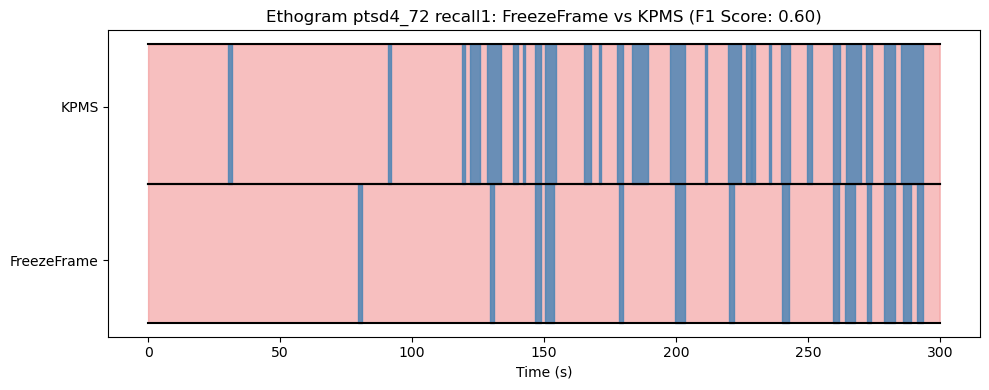

Plotted ethogram for Cohort ID: ptsd4_72, Day: recall1, F1 Score: 0.60


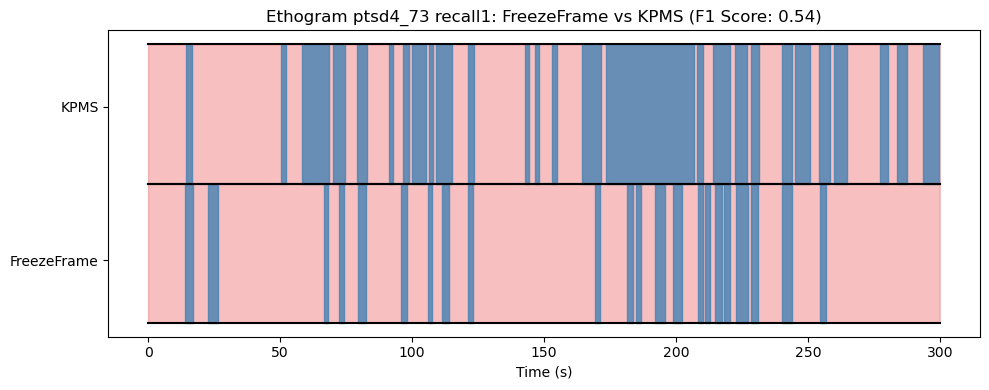

Plotted ethogram for Cohort ID: ptsd4_73, Day: recall1, F1 Score: 0.54


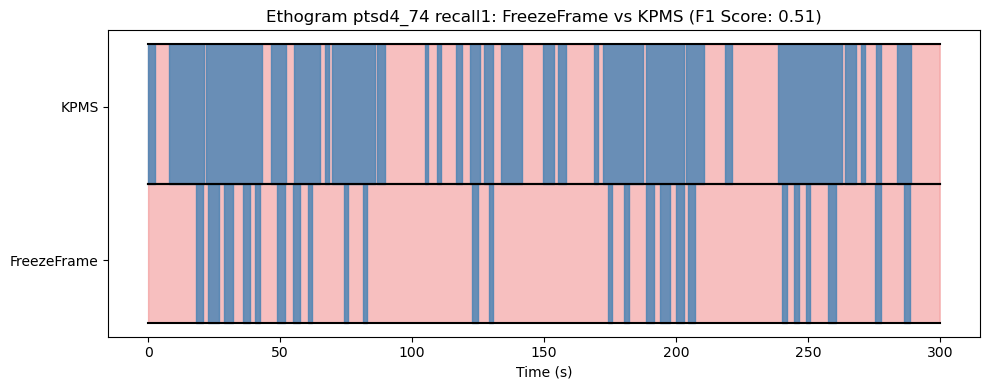

Plotted ethogram for Cohort ID: ptsd4_74, Day: recall1, F1 Score: 0.51


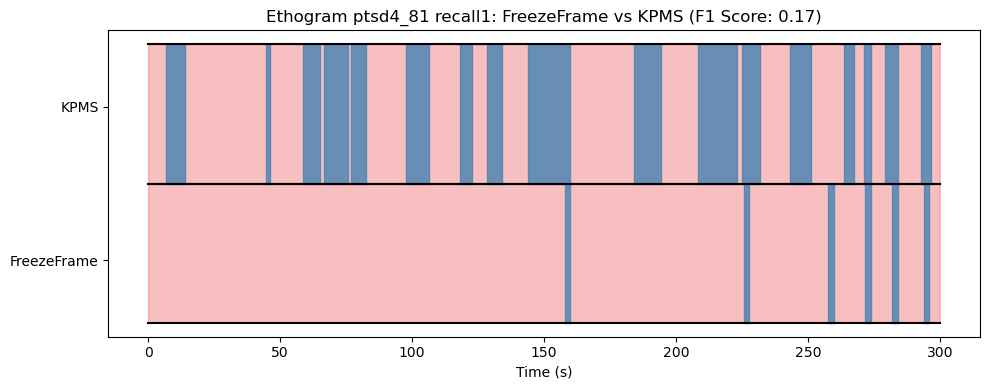

Plotted ethogram for Cohort ID: ptsd4_81, Day: recall1, F1 Score: 0.17


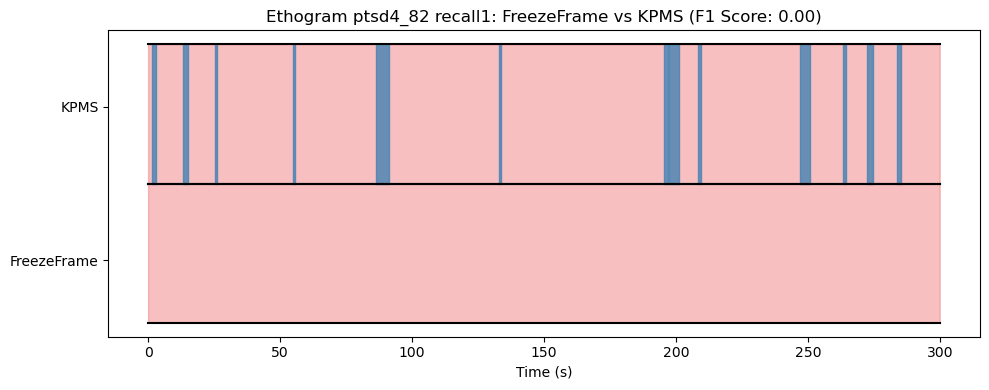

Plotted ethogram for Cohort ID: ptsd4_82, Day: recall1, F1 Score: 0.00


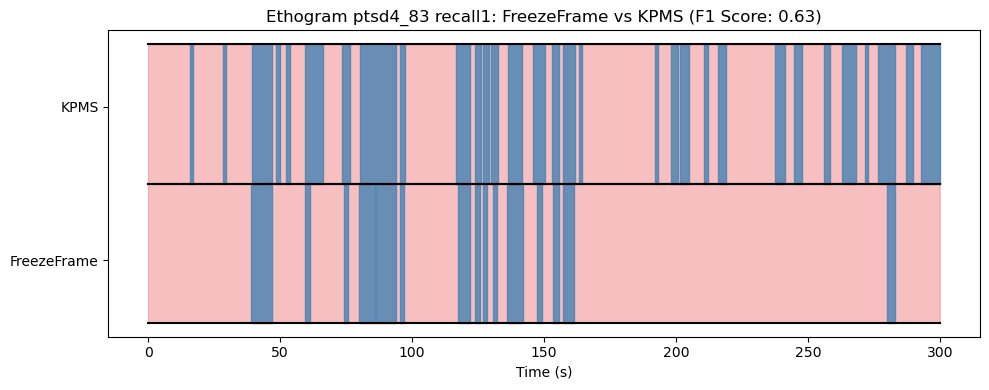

Plotted ethogram for Cohort ID: ptsd4_83, Day: recall1, F1 Score: 0.63


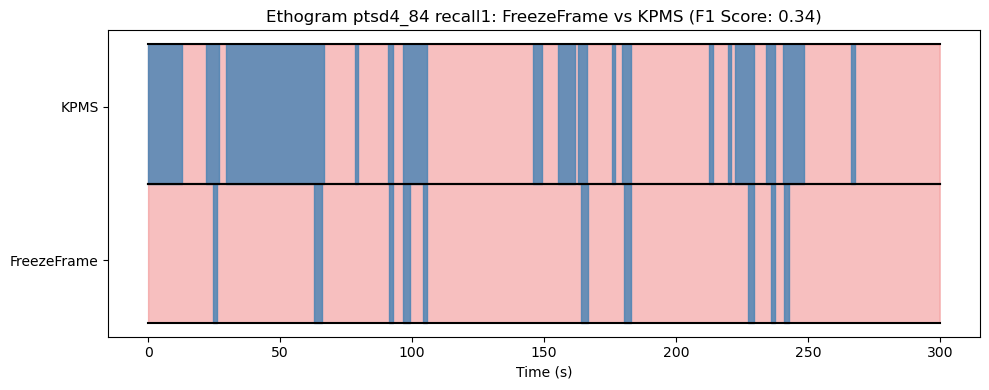

Plotted ethogram for Cohort ID: ptsd4_84, Day: recall1, F1 Score: 0.34


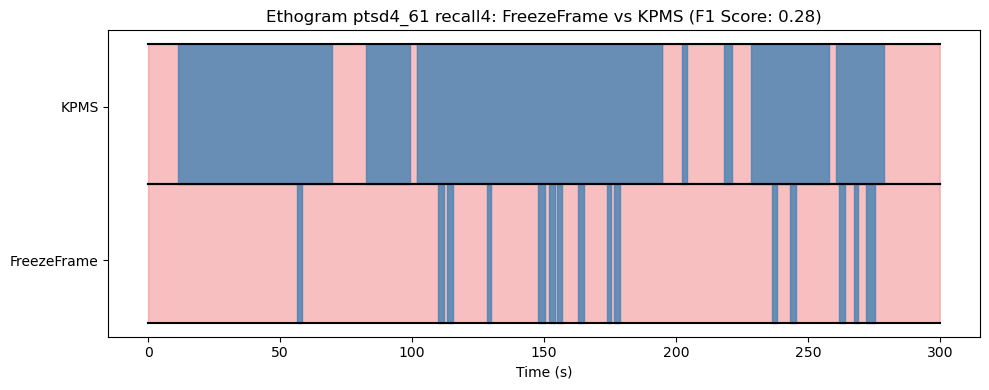

Plotted ethogram for Cohort ID: ptsd4_61, Day: recall4, F1 Score: 0.28


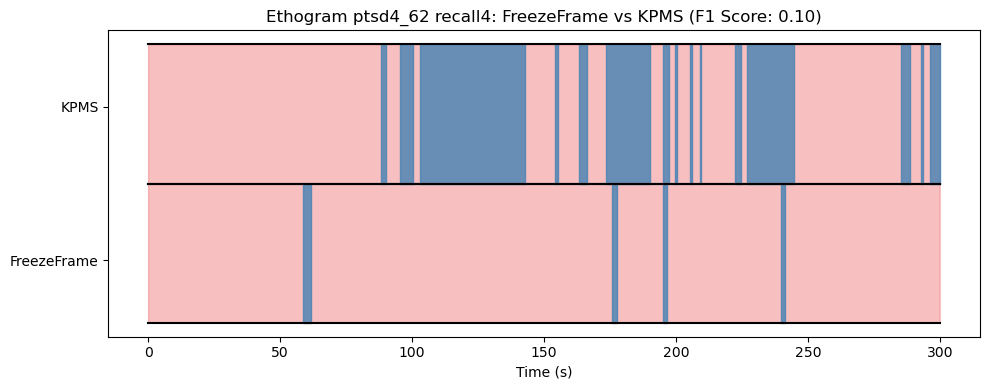

Plotted ethogram for Cohort ID: ptsd4_62, Day: recall4, F1 Score: 0.10


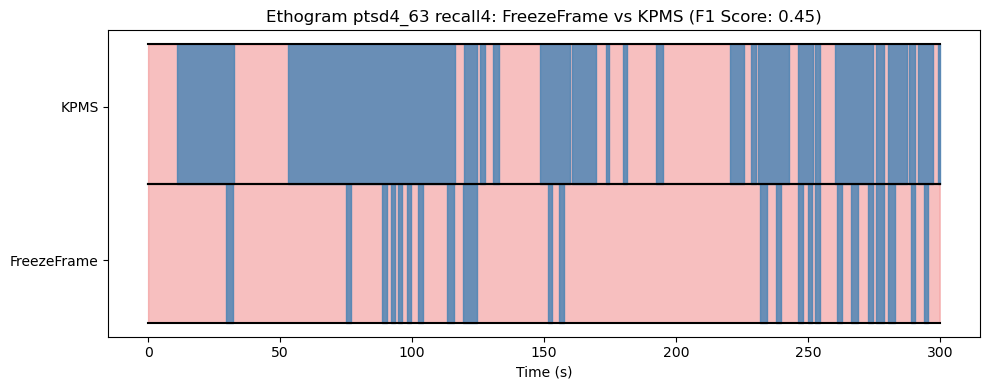

Plotted ethogram for Cohort ID: ptsd4_63, Day: recall4, F1 Score: 0.45


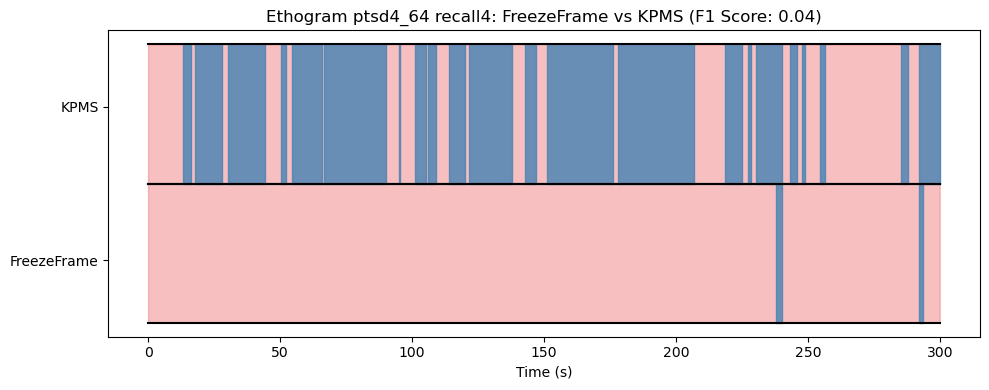

Plotted ethogram for Cohort ID: ptsd4_64, Day: recall4, F1 Score: 0.04


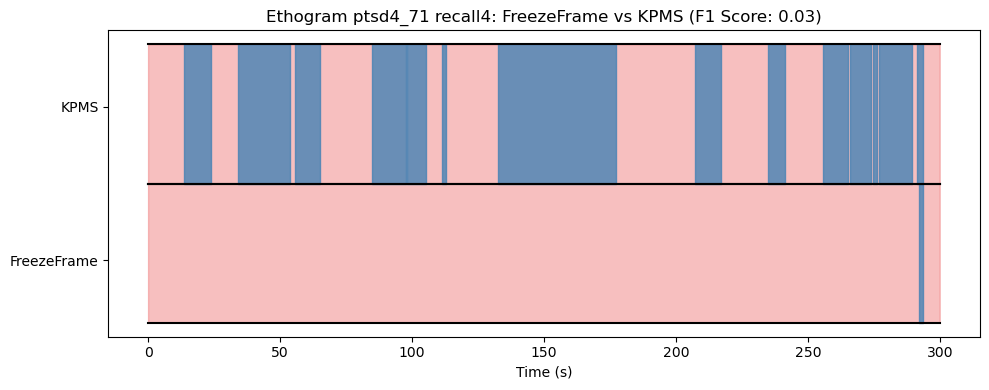

Plotted ethogram for Cohort ID: ptsd4_71, Day: recall4, F1 Score: 0.03


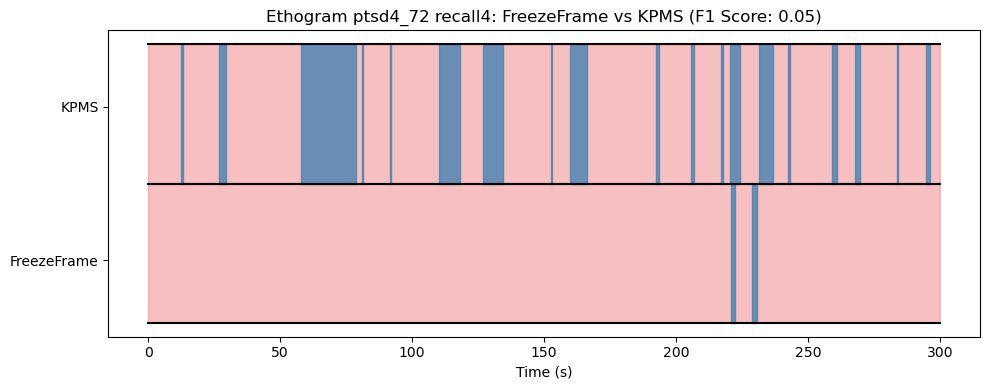

Plotted ethogram for Cohort ID: ptsd4_72, Day: recall4, F1 Score: 0.05


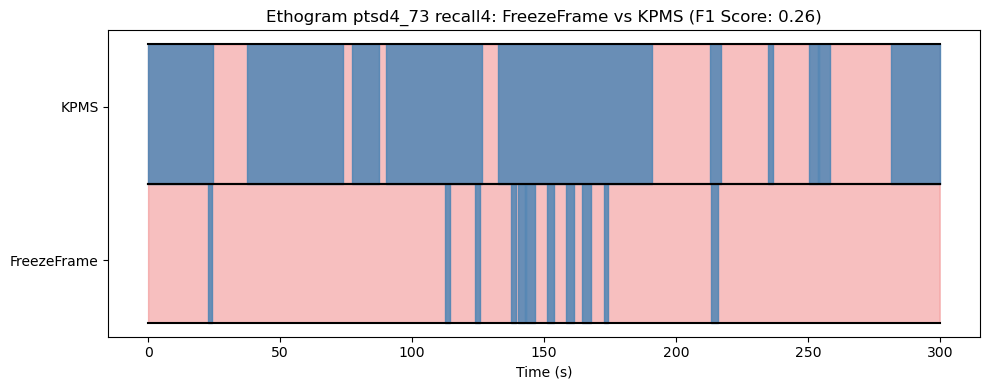

Plotted ethogram for Cohort ID: ptsd4_73, Day: recall4, F1 Score: 0.26


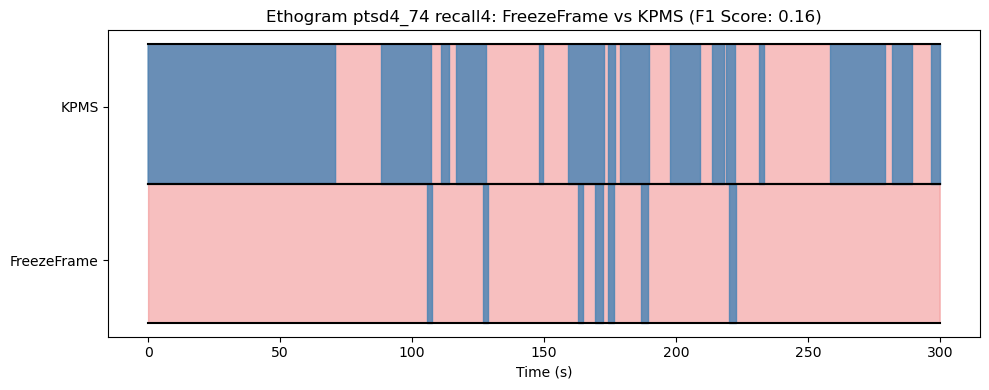

Plotted ethogram for Cohort ID: ptsd4_74, Day: recall4, F1 Score: 0.16


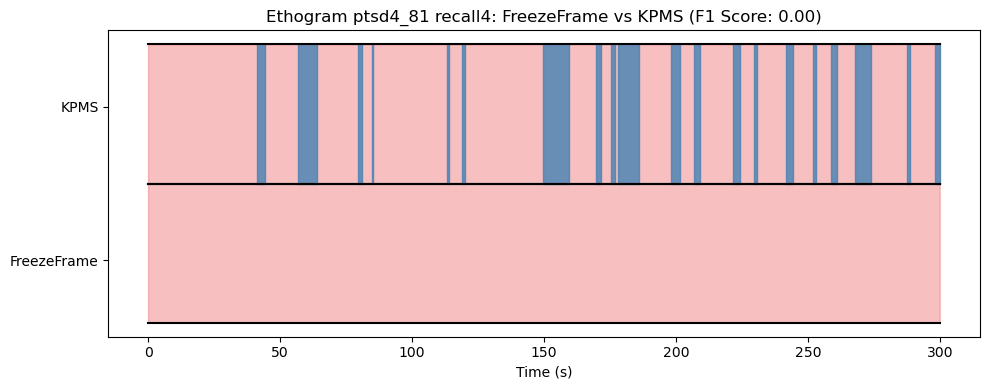

Plotted ethogram for Cohort ID: ptsd4_81, Day: recall4, F1 Score: 0.00


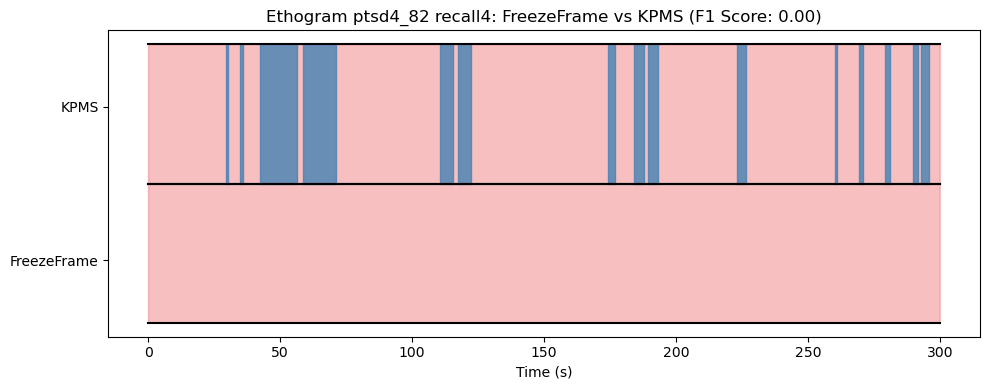

Plotted ethogram for Cohort ID: ptsd4_82, Day: recall4, F1 Score: 0.00


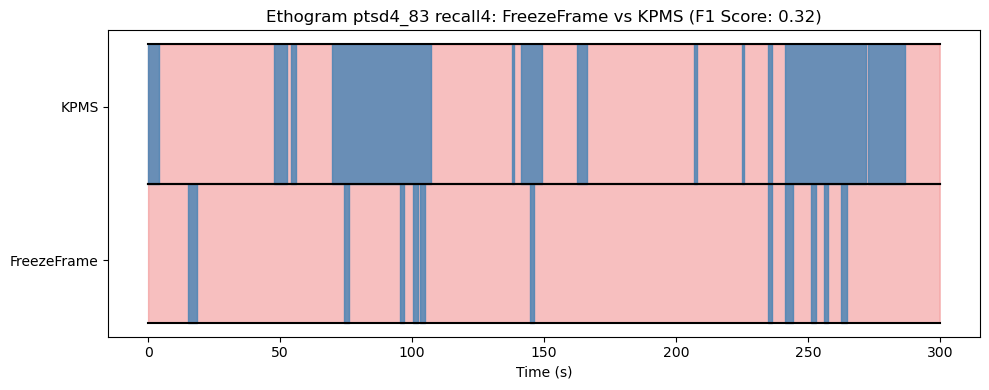

Plotted ethogram for Cohort ID: ptsd4_83, Day: recall4, F1 Score: 0.32


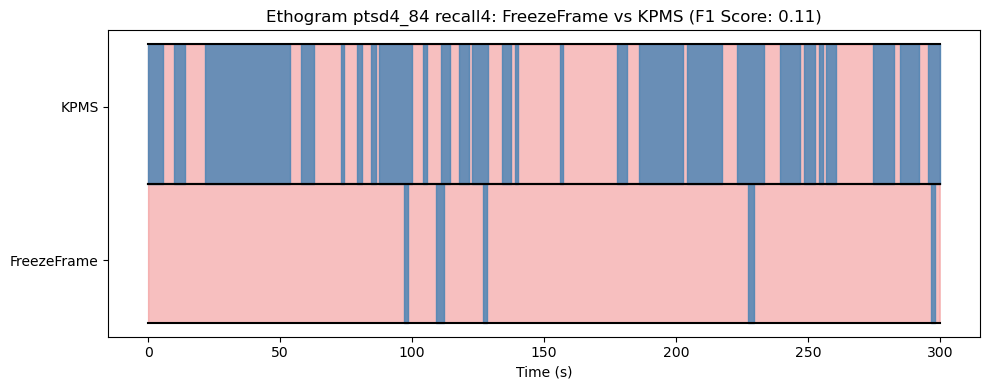

Plotted ethogram for Cohort ID: ptsd4_84, Day: recall4, F1 Score: 0.11


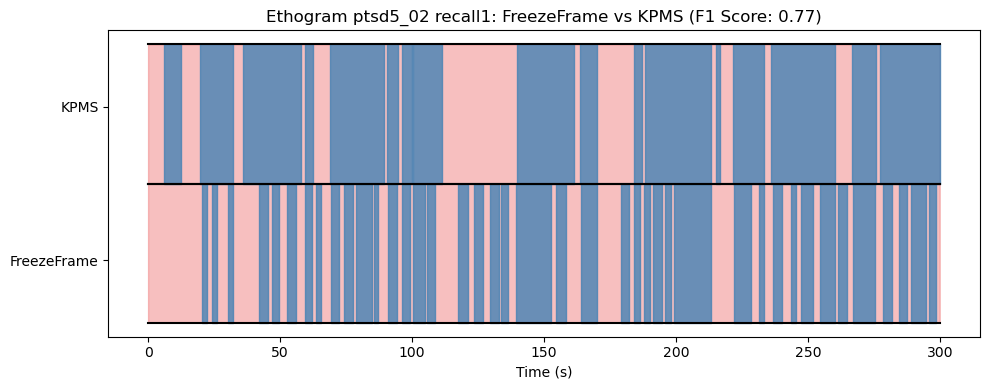

Unexpected condition: nan
Plotted ethogram for Cohort ID: ptsd5_02, Day: recall1, F1 Score: 0.77


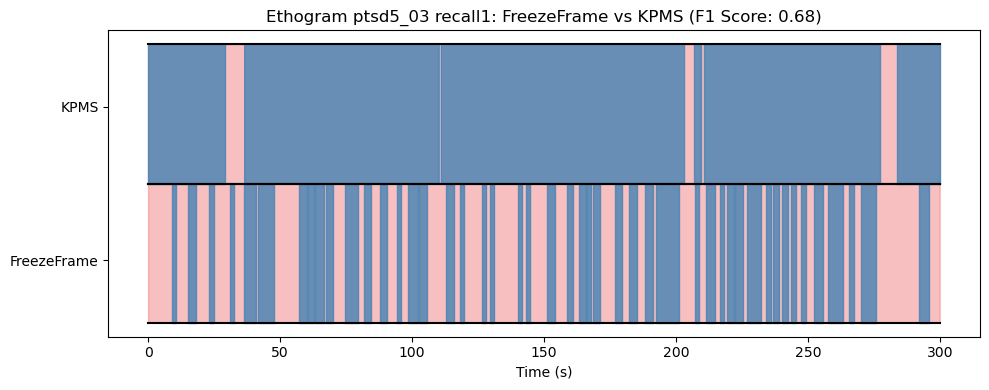

Unexpected condition: nan
Plotted ethogram for Cohort ID: ptsd5_03, Day: recall1, F1 Score: 0.68


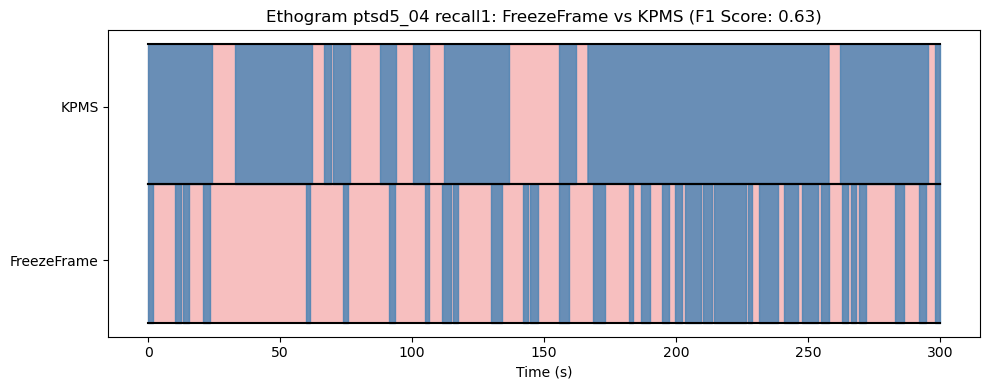

Unexpected condition: nan
Plotted ethogram for Cohort ID: ptsd5_04, Day: recall1, F1 Score: 0.63


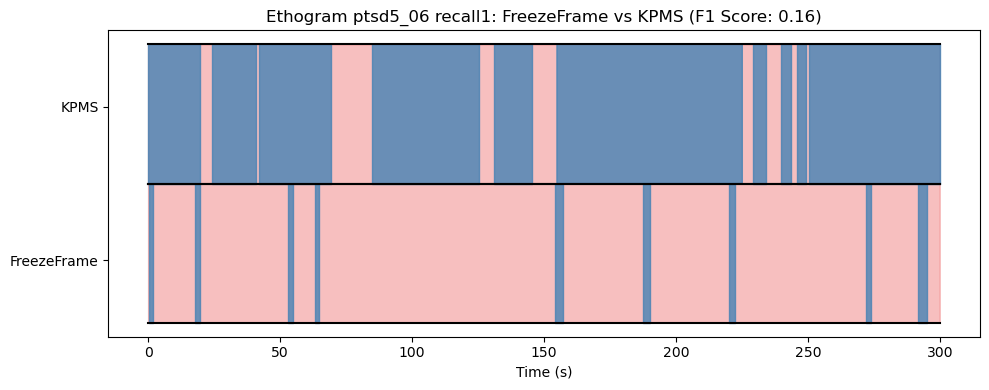

Unexpected condition: nan
Plotted ethogram for Cohort ID: ptsd5_06, Day: recall1, F1 Score: 0.16


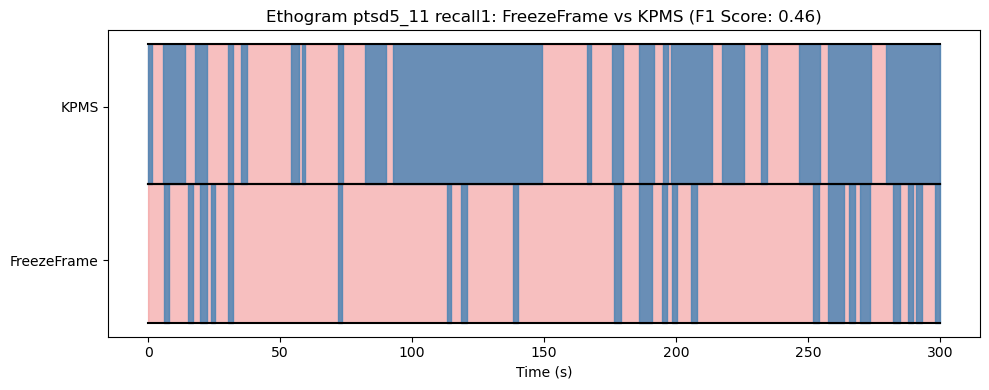

Plotted ethogram for Cohort ID: ptsd5_11, Day: recall1, F1 Score: 0.46


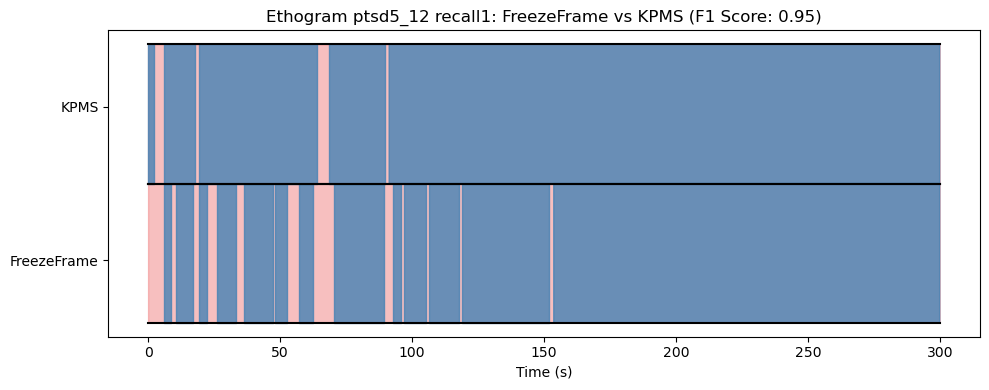

Plotted ethogram for Cohort ID: ptsd5_12, Day: recall1, F1 Score: 0.95


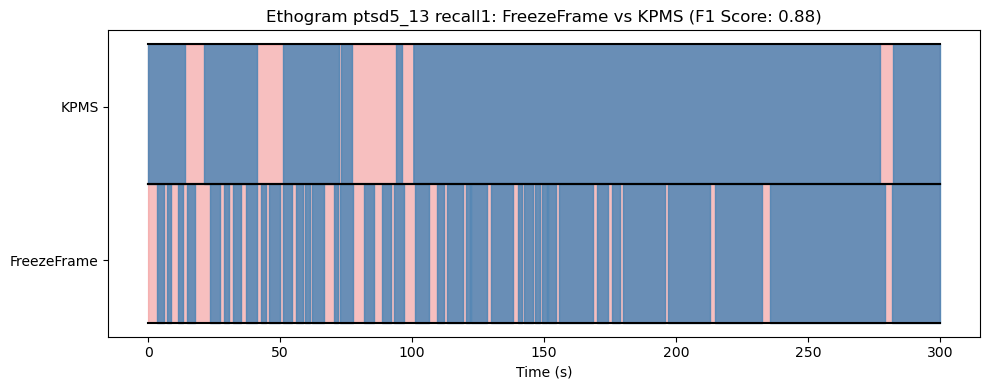

Plotted ethogram for Cohort ID: ptsd5_13, Day: recall1, F1 Score: 0.88


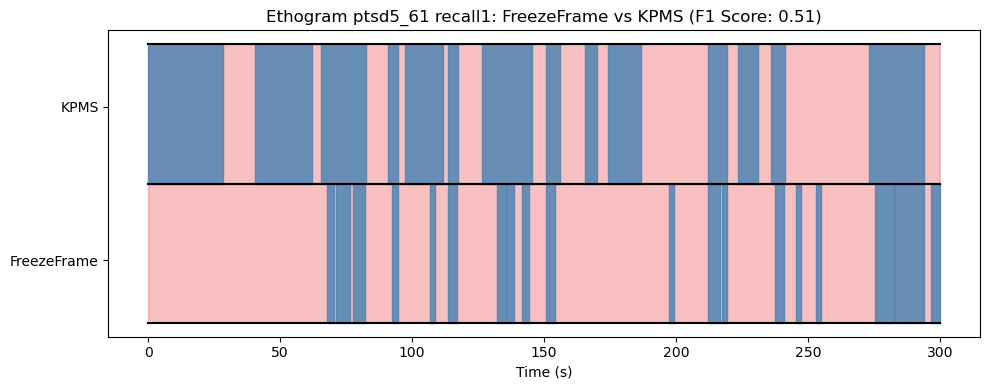

Plotted ethogram for Cohort ID: ptsd5_61, Day: recall1, F1 Score: 0.51


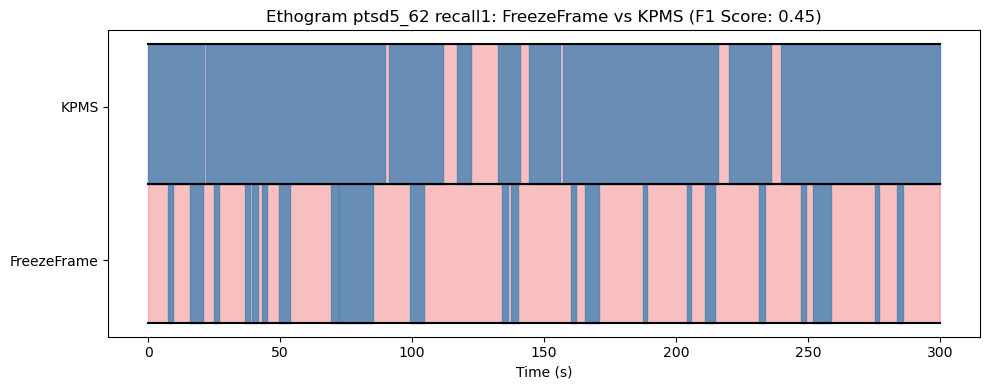

Plotted ethogram for Cohort ID: ptsd5_62, Day: recall1, F1 Score: 0.45


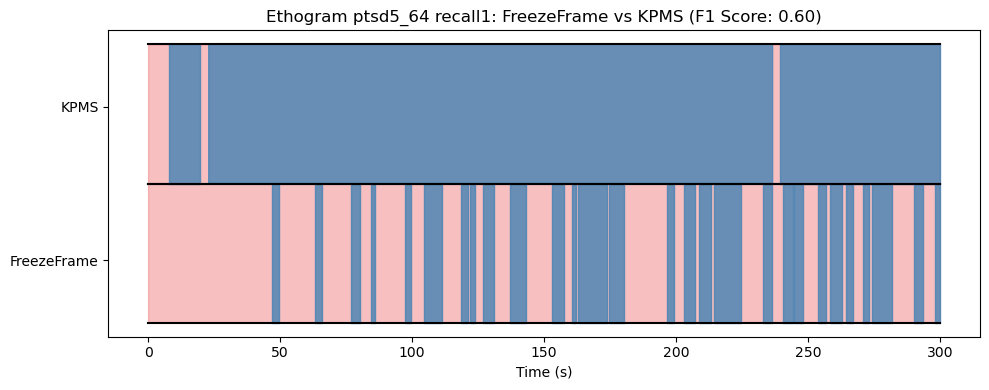

Plotted ethogram for Cohort ID: ptsd5_64, Day: recall1, F1 Score: 0.60


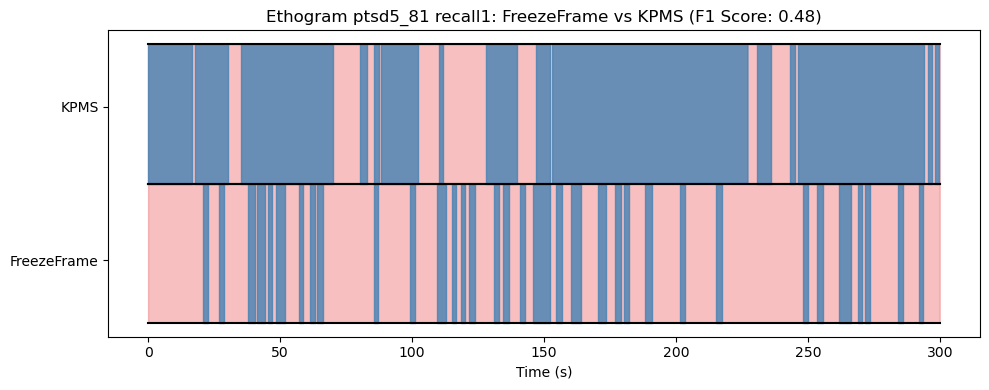

Plotted ethogram for Cohort ID: ptsd5_81, Day: recall1, F1 Score: 0.48


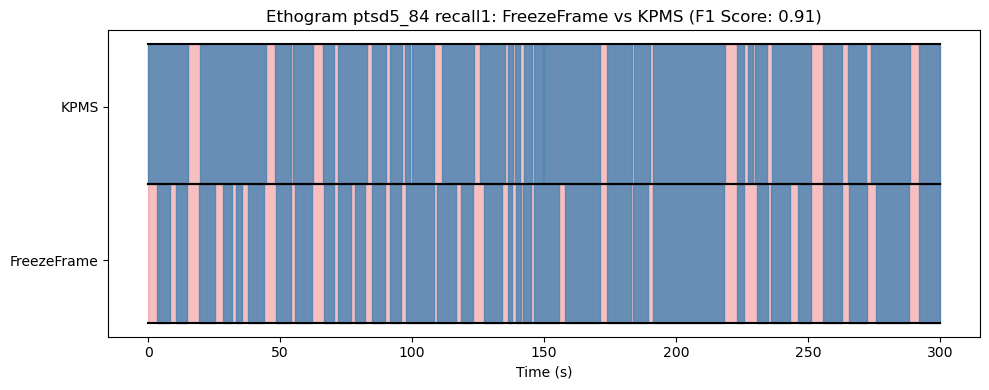

Plotted ethogram for Cohort ID: ptsd5_84, Day: recall1, F1 Score: 0.91


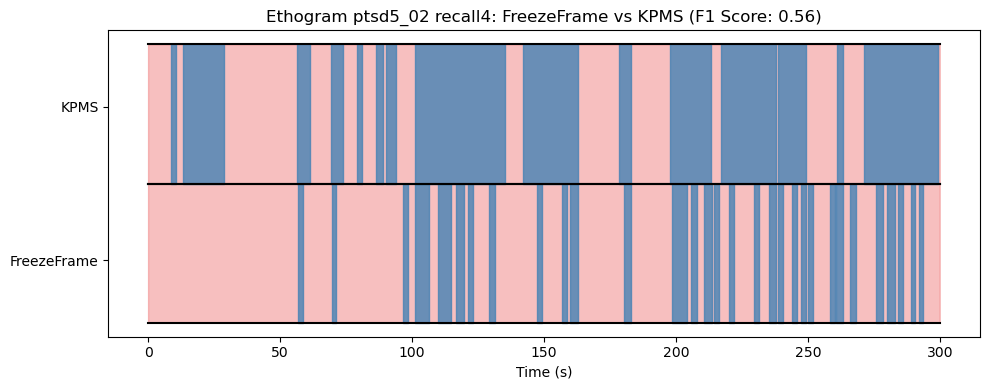

Unexpected condition: nan
Plotted ethogram for Cohort ID: ptsd5_02, Day: recall4, F1 Score: 0.56


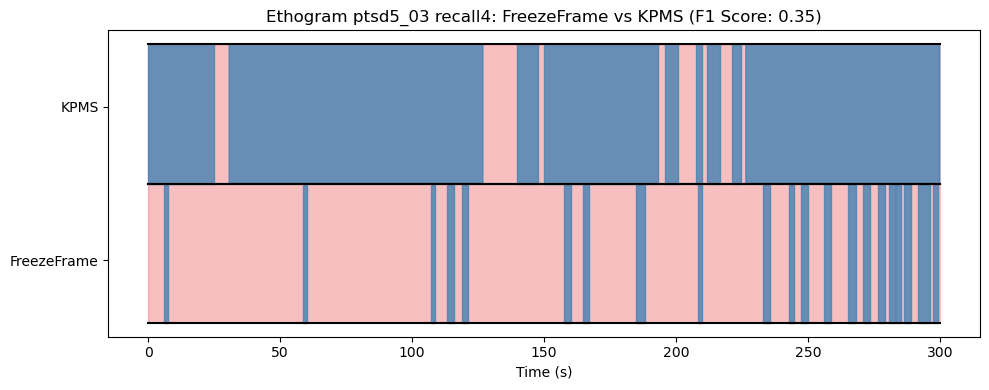

Unexpected condition: nan
Plotted ethogram for Cohort ID: ptsd5_03, Day: recall4, F1 Score: 0.35


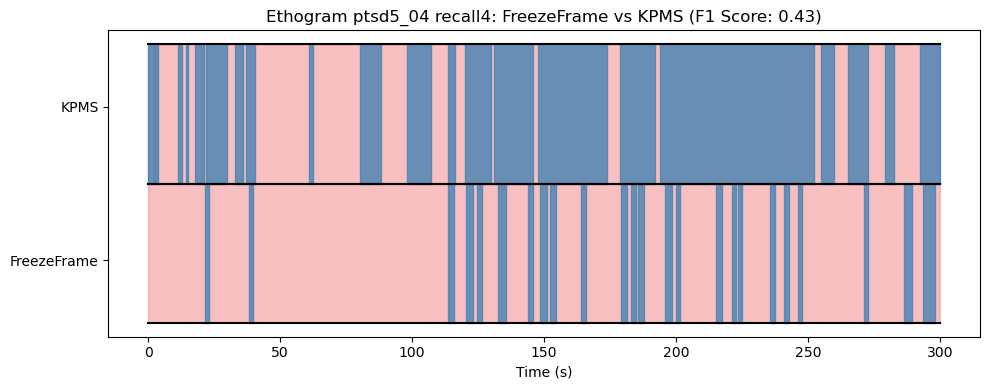

Unexpected condition: nan
Plotted ethogram for Cohort ID: ptsd5_04, Day: recall4, F1 Score: 0.43


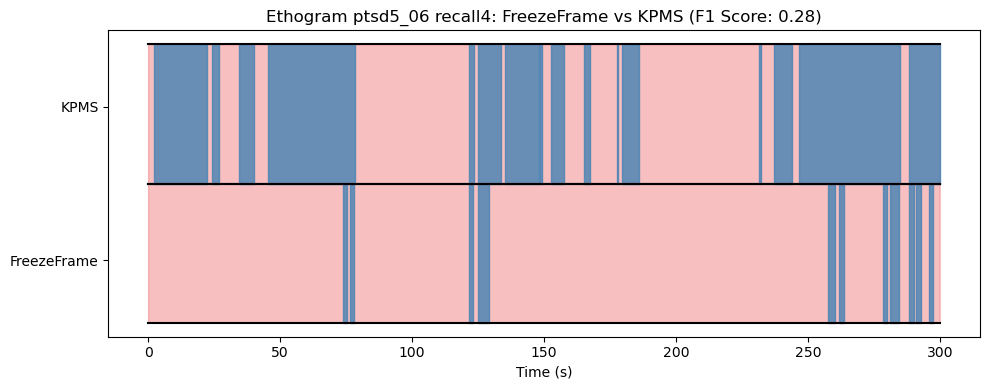

Unexpected condition: nan
Plotted ethogram for Cohort ID: ptsd5_06, Day: recall4, F1 Score: 0.28


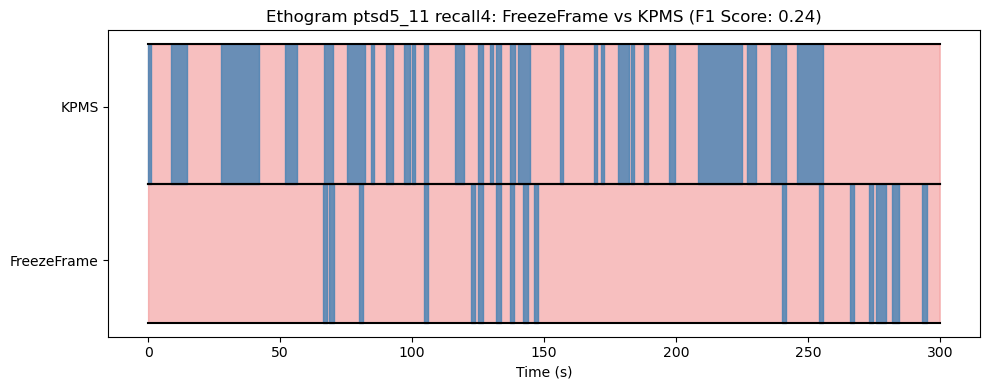

Plotted ethogram for Cohort ID: ptsd5_11, Day: recall4, F1 Score: 0.24


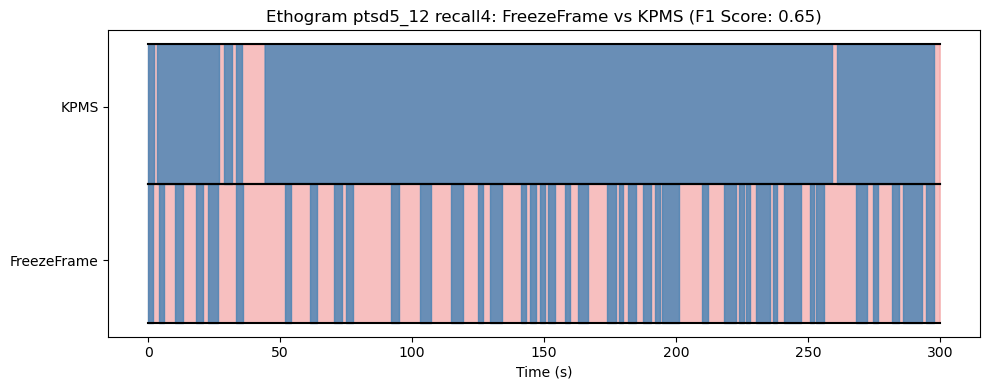

Plotted ethogram for Cohort ID: ptsd5_12, Day: recall4, F1 Score: 0.65


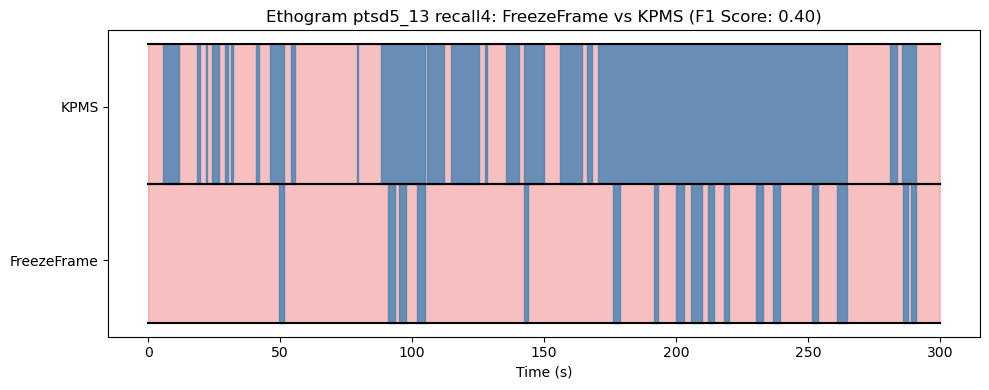

Plotted ethogram for Cohort ID: ptsd5_13, Day: recall4, F1 Score: 0.40


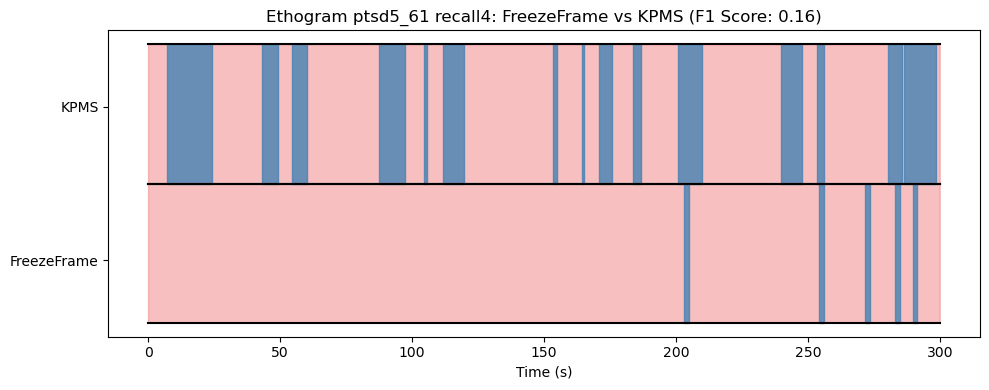

Plotted ethogram for Cohort ID: ptsd5_61, Day: recall4, F1 Score: 0.16


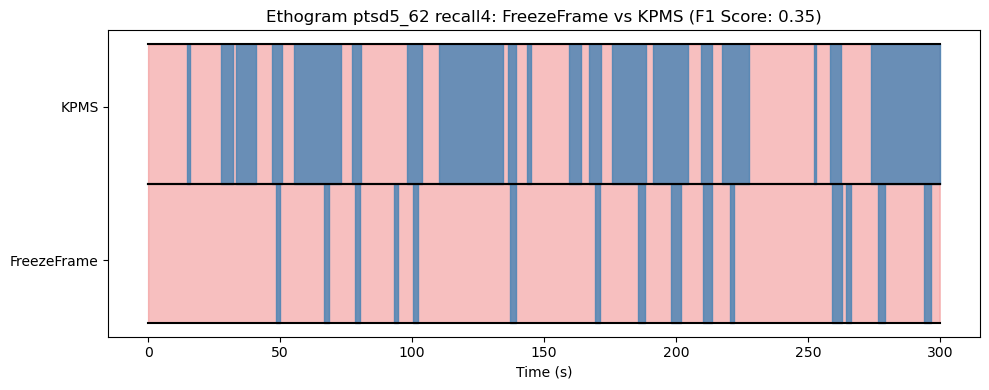

Plotted ethogram for Cohort ID: ptsd5_62, Day: recall4, F1 Score: 0.35


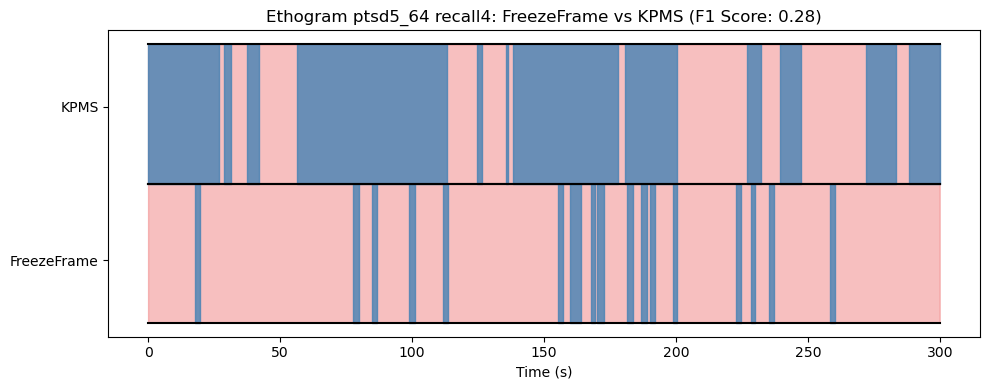

Plotted ethogram for Cohort ID: ptsd5_64, Day: recall4, F1 Score: 0.28


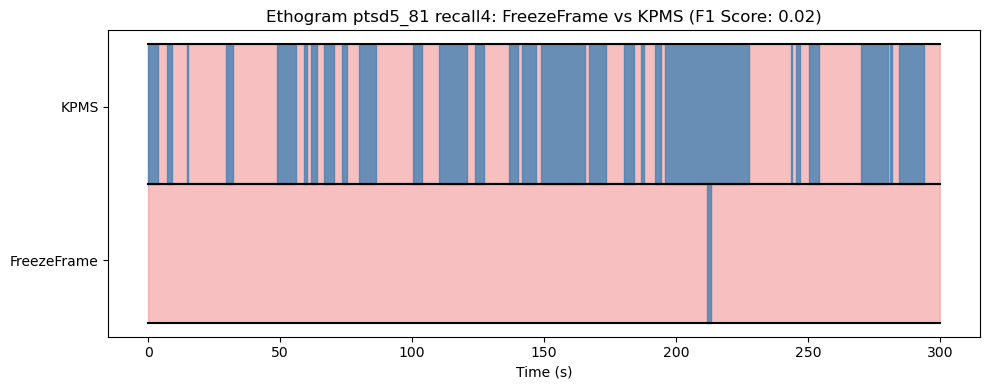

Plotted ethogram for Cohort ID: ptsd5_81, Day: recall4, F1 Score: 0.02
Skipping plot for Cohort ID: ptsd5_83, Day: recall4 due to empty data.


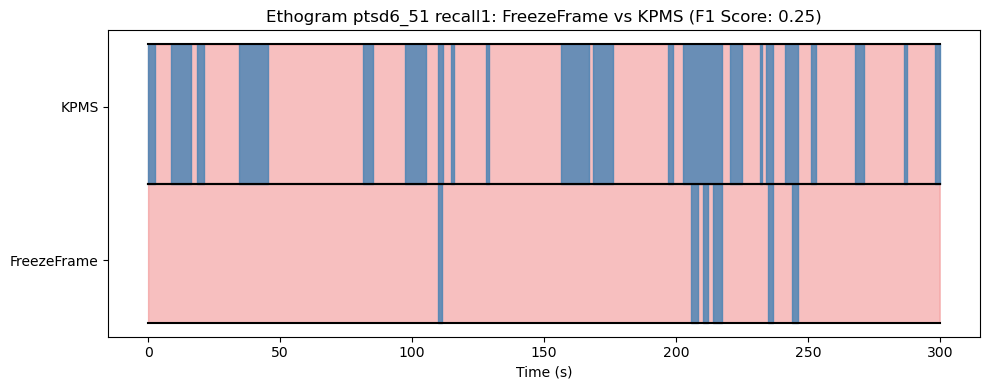

Plotted ethogram for Cohort ID: ptsd6_51, Day: recall1, F1 Score: 0.25


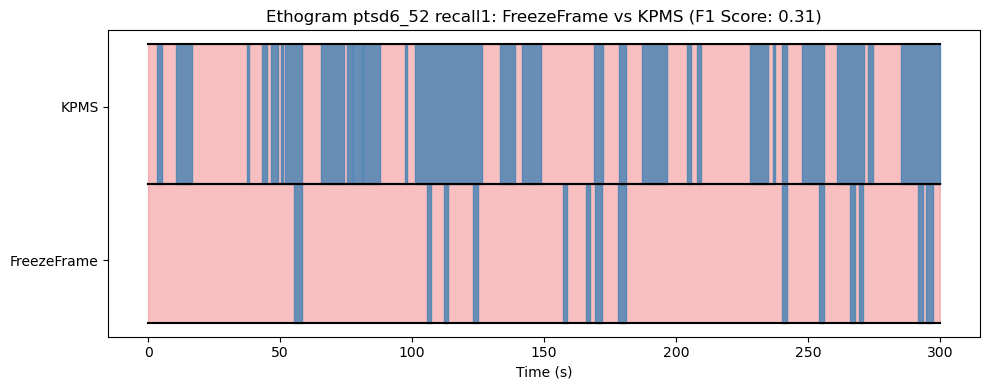

Plotted ethogram for Cohort ID: ptsd6_52, Day: recall1, F1 Score: 0.31


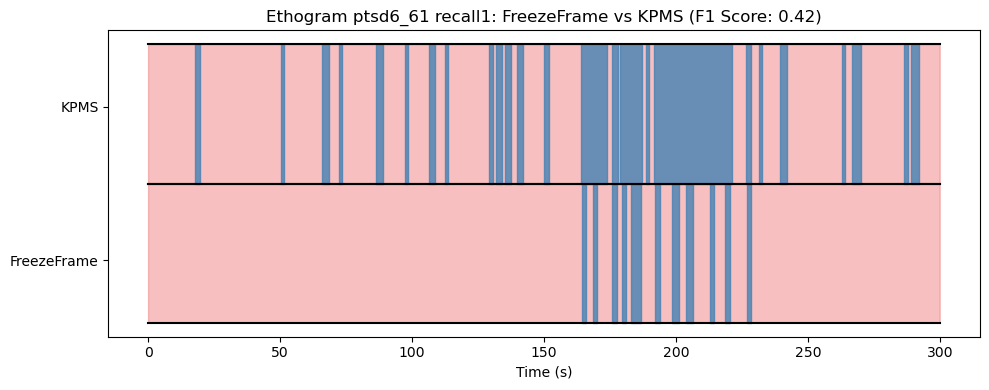

Plotted ethogram for Cohort ID: ptsd6_61, Day: recall1, F1 Score: 0.42


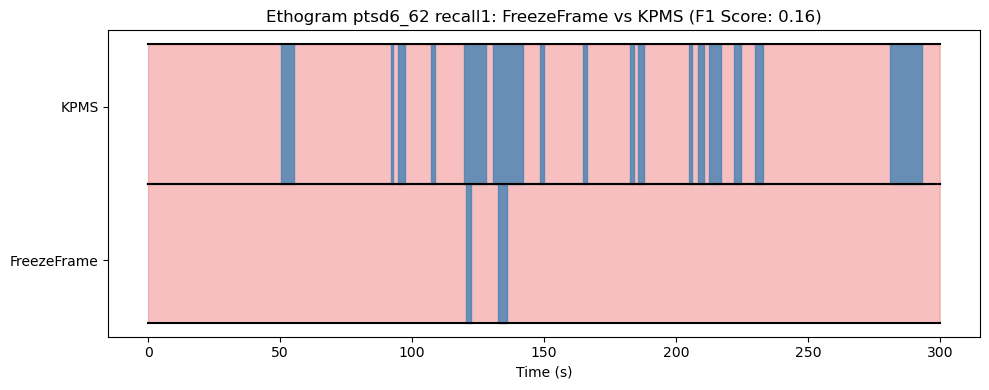

Plotted ethogram for Cohort ID: ptsd6_62, Day: recall1, F1 Score: 0.16


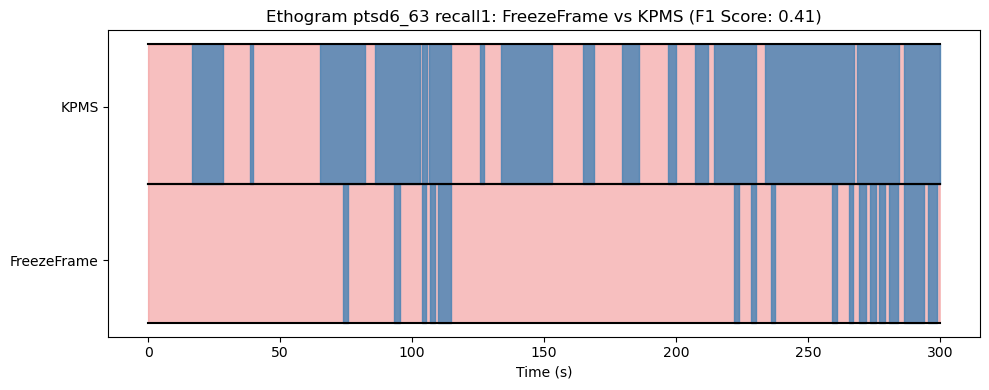

Plotted ethogram for Cohort ID: ptsd6_63, Day: recall1, F1 Score: 0.41


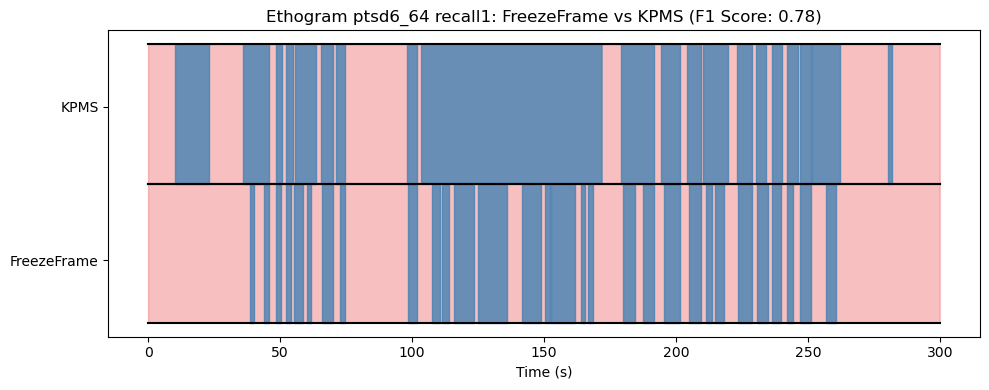

Plotted ethogram for Cohort ID: ptsd6_64, Day: recall1, F1 Score: 0.78


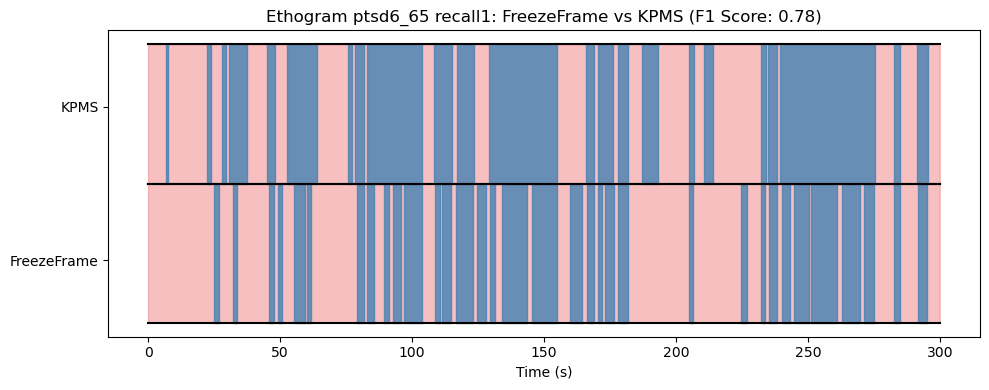

Plotted ethogram for Cohort ID: ptsd6_65, Day: recall1, F1 Score: 0.78


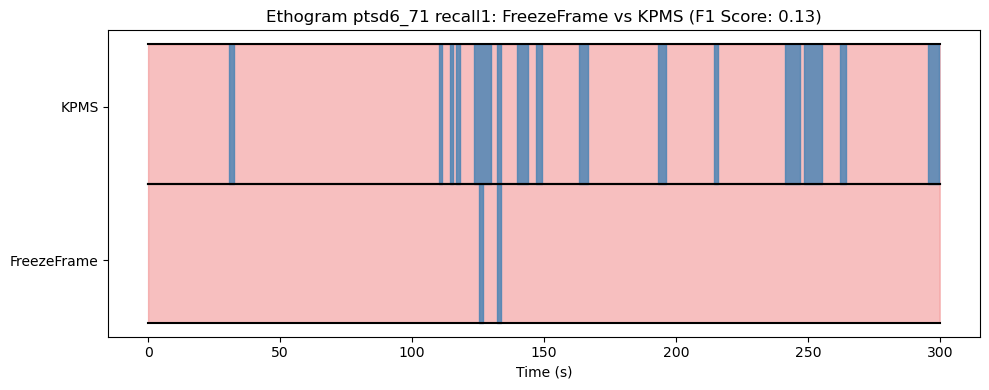

Plotted ethogram for Cohort ID: ptsd6_71, Day: recall1, F1 Score: 0.13


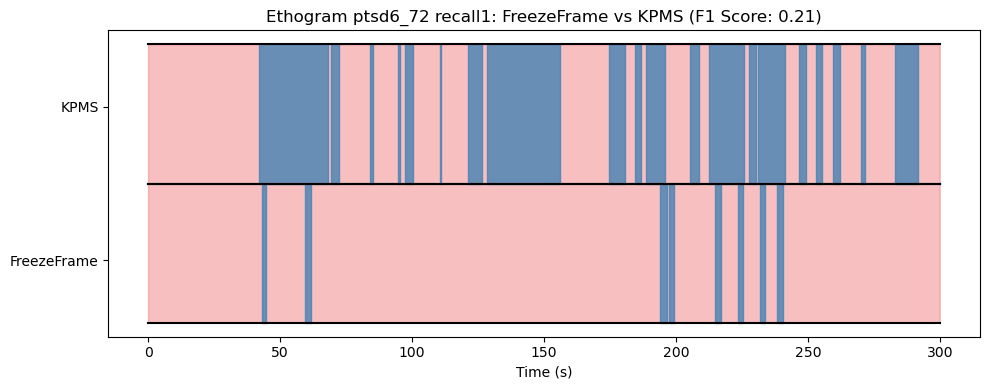

Plotted ethogram for Cohort ID: ptsd6_72, Day: recall1, F1 Score: 0.21


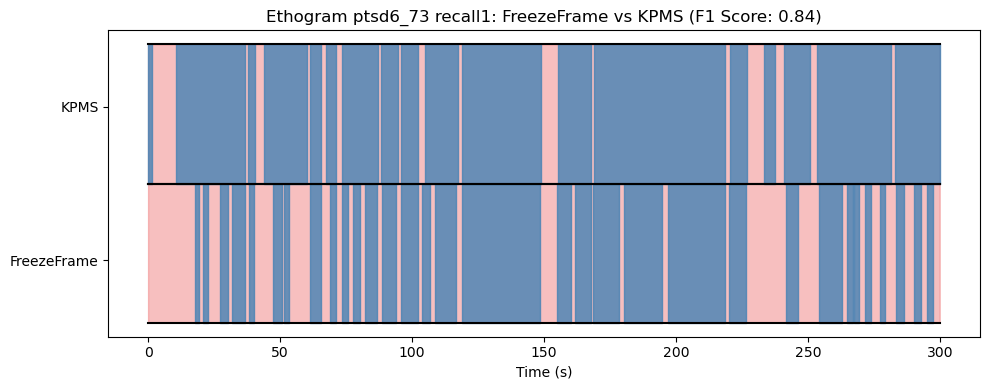

Plotted ethogram for Cohort ID: ptsd6_73, Day: recall1, F1 Score: 0.84


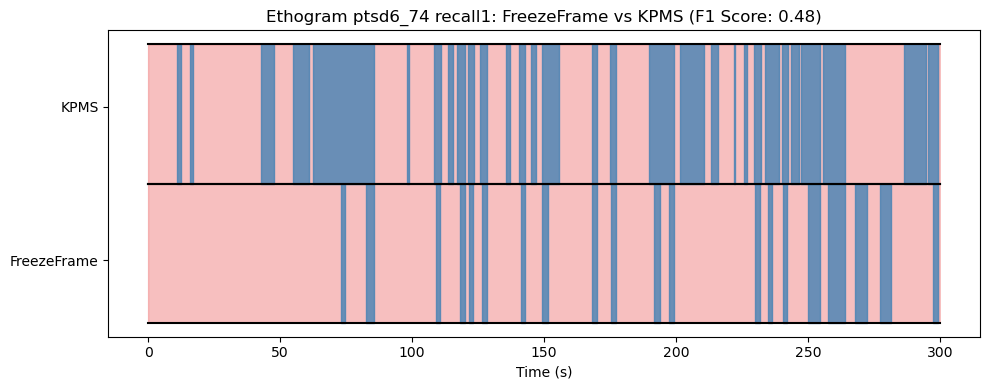

Plotted ethogram for Cohort ID: ptsd6_74, Day: recall1, F1 Score: 0.48


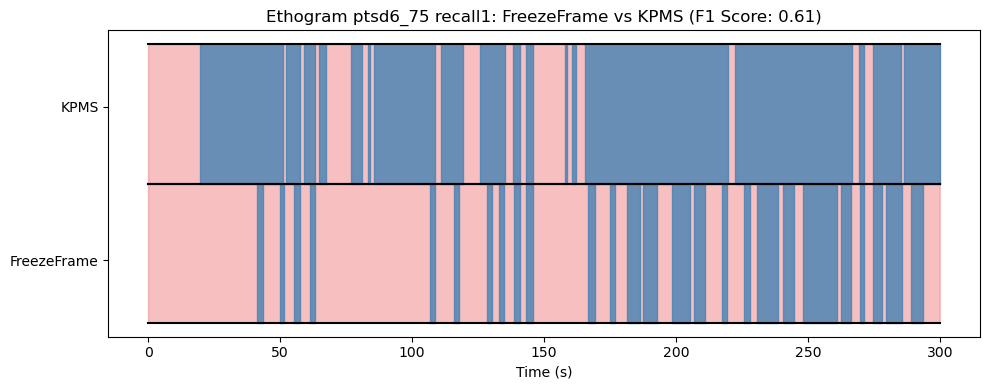

Plotted ethogram for Cohort ID: ptsd6_75, Day: recall1, F1 Score: 0.61


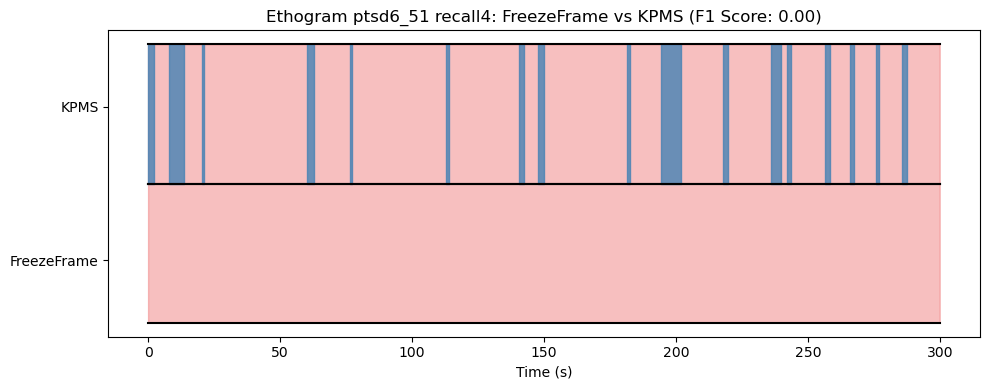

Plotted ethogram for Cohort ID: ptsd6_51, Day: recall4, F1 Score: 0.00


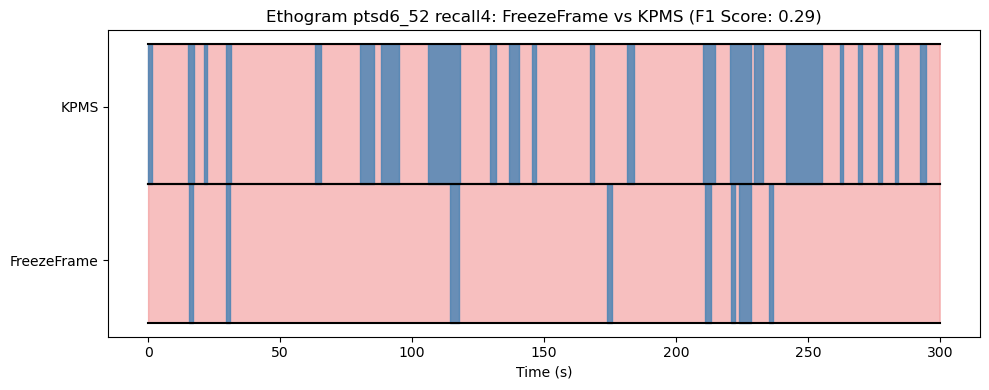

Plotted ethogram for Cohort ID: ptsd6_52, Day: recall4, F1 Score: 0.29


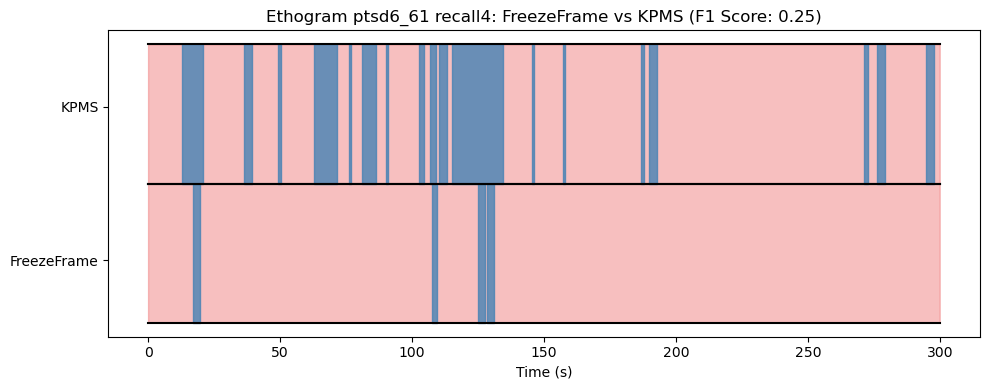

Plotted ethogram for Cohort ID: ptsd6_61, Day: recall4, F1 Score: 0.25


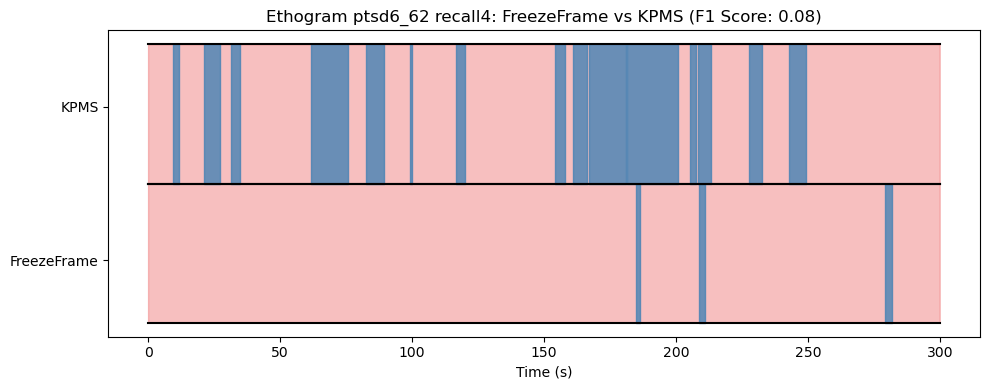

Plotted ethogram for Cohort ID: ptsd6_62, Day: recall4, F1 Score: 0.08


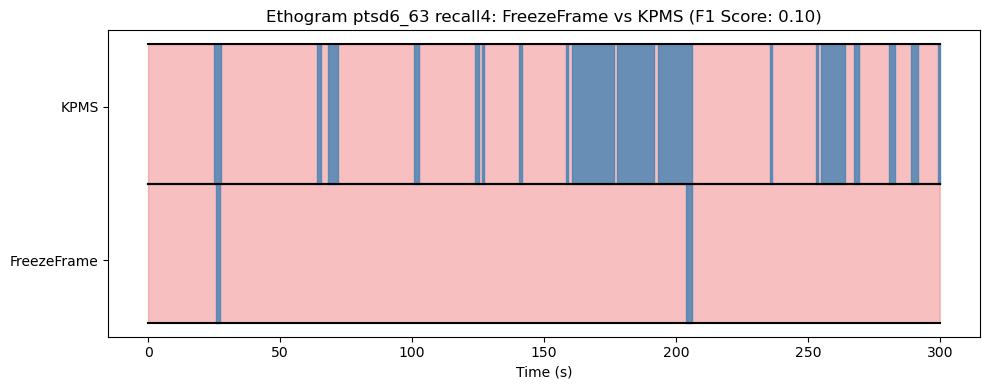

Plotted ethogram for Cohort ID: ptsd6_63, Day: recall4, F1 Score: 0.10


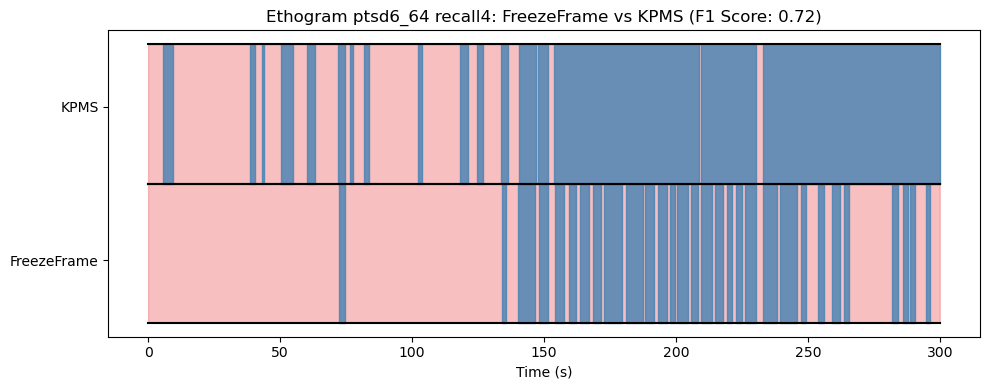

Plotted ethogram for Cohort ID: ptsd6_64, Day: recall4, F1 Score: 0.72


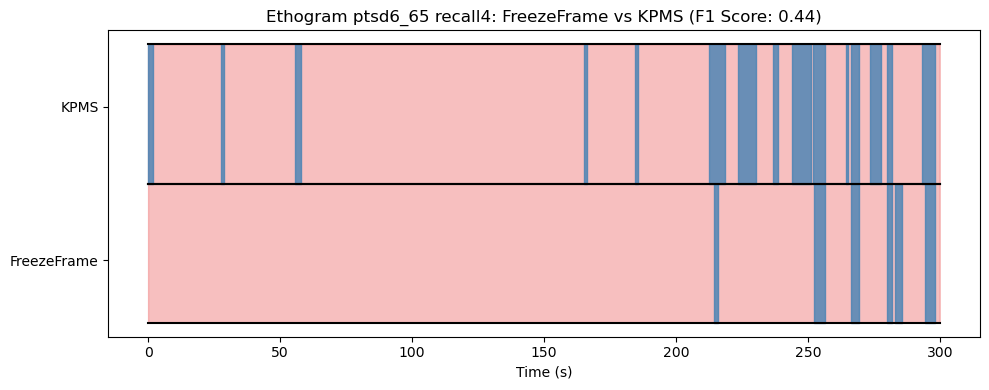

Plotted ethogram for Cohort ID: ptsd6_65, Day: recall4, F1 Score: 0.44


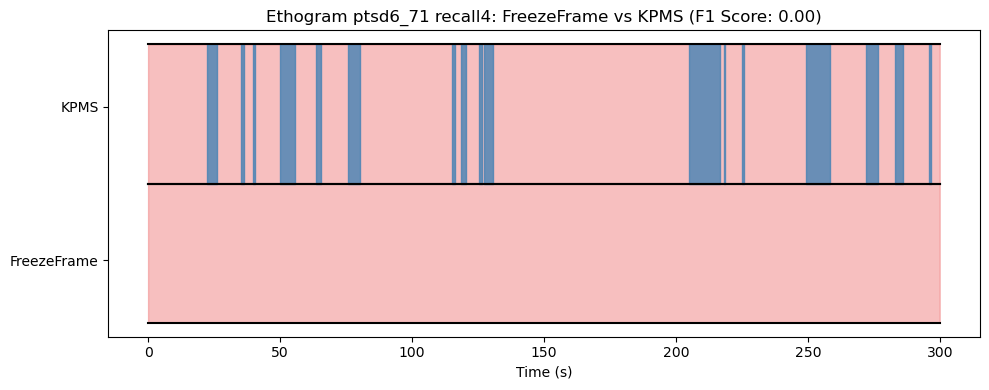

Plotted ethogram for Cohort ID: ptsd6_71, Day: recall4, F1 Score: 0.00


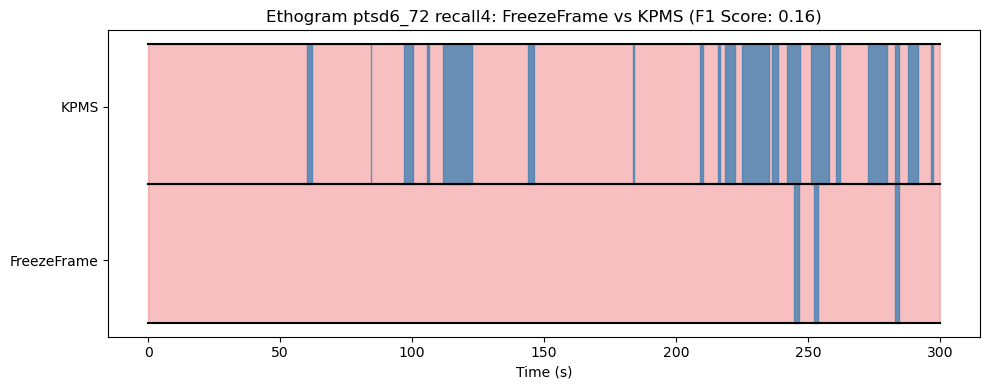

Plotted ethogram for Cohort ID: ptsd6_72, Day: recall4, F1 Score: 0.16


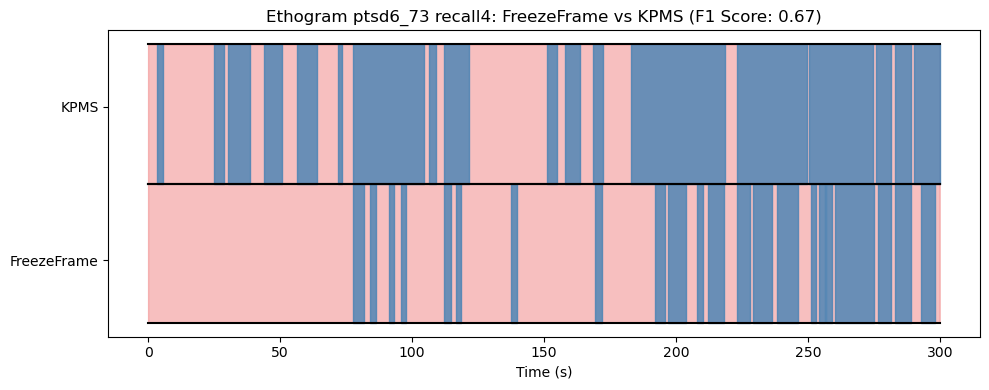

Plotted ethogram for Cohort ID: ptsd6_73, Day: recall4, F1 Score: 0.67


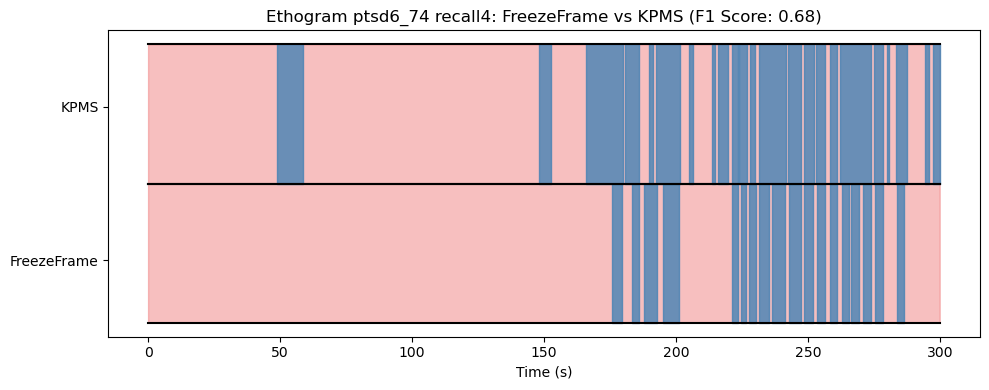

Plotted ethogram for Cohort ID: ptsd6_74, Day: recall4, F1 Score: 0.68


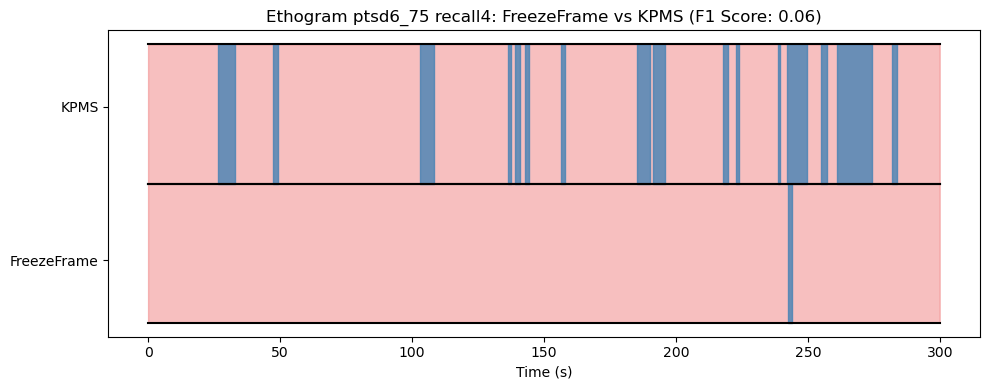

Plotted ethogram for Cohort ID: ptsd6_75, Day: recall4, F1 Score: 0.06


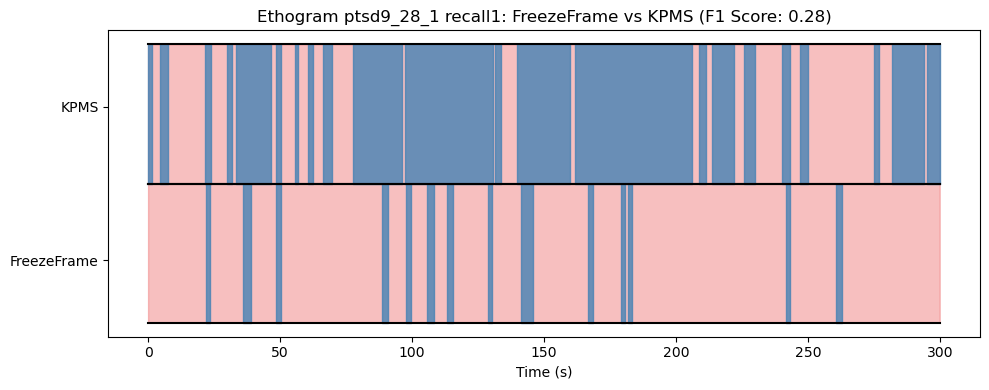

Plotted ethogram for Cohort ID: ptsd9_28_1, Day: recall1, F1 Score: 0.28


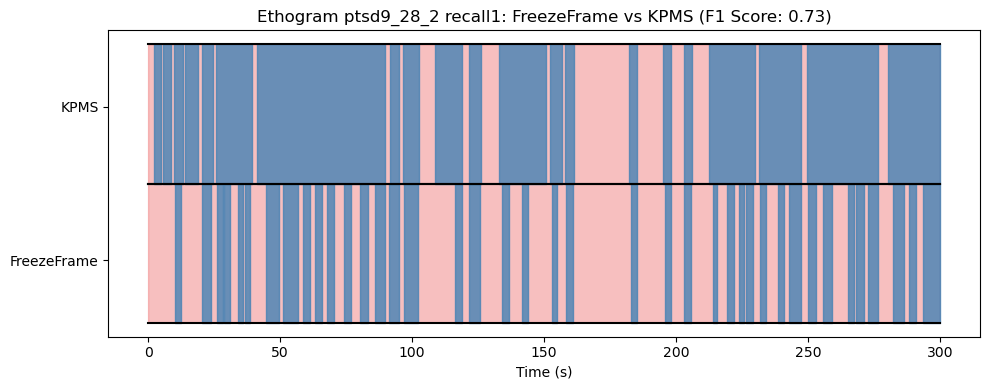

Plotted ethogram for Cohort ID: ptsd9_28_2, Day: recall1, F1 Score: 0.73


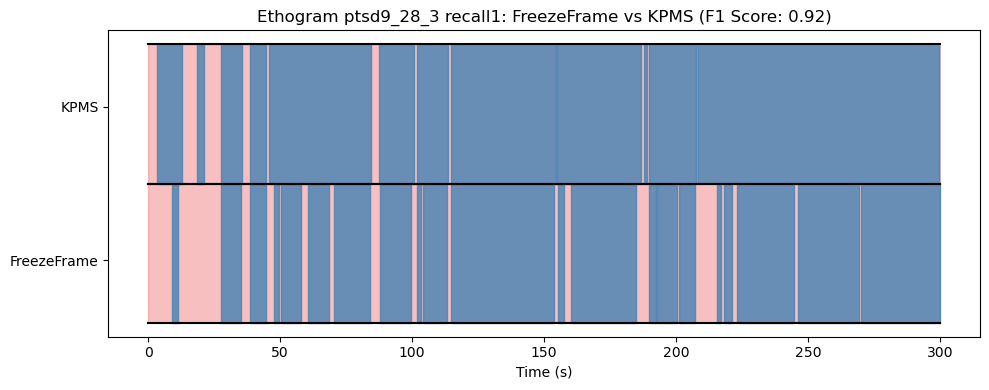

Plotted ethogram for Cohort ID: ptsd9_28_3, Day: recall1, F1 Score: 0.92


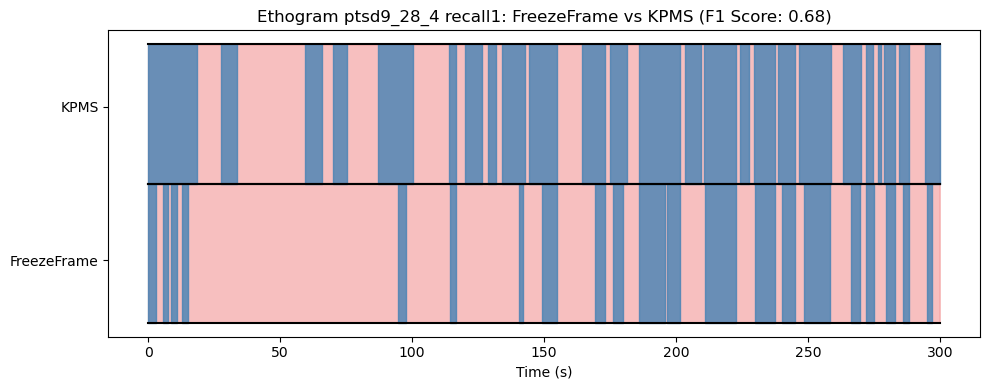

Plotted ethogram for Cohort ID: ptsd9_28_4, Day: recall1, F1 Score: 0.68


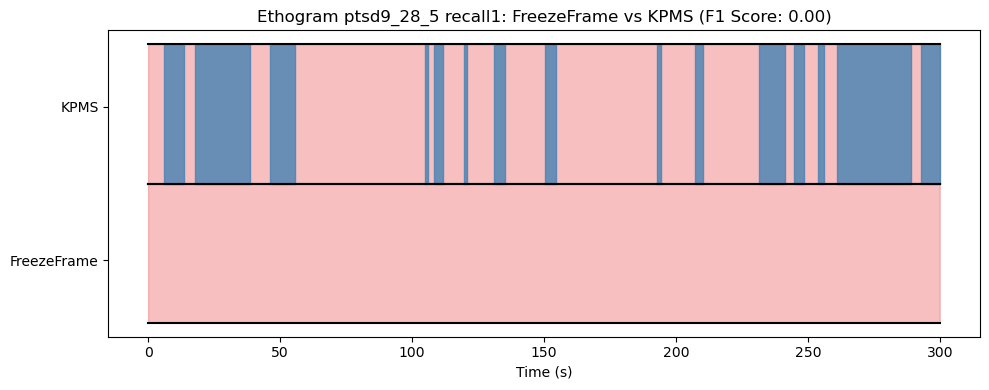

Plotted ethogram for Cohort ID: ptsd9_28_5, Day: recall1, F1 Score: 0.00


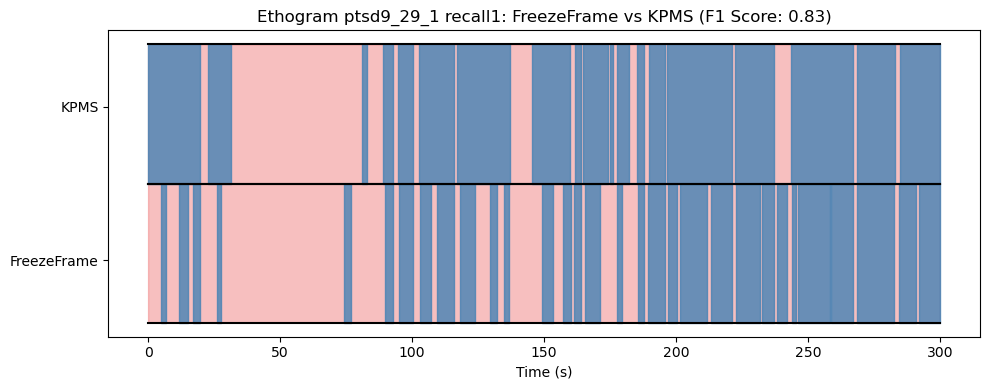

Plotted ethogram for Cohort ID: ptsd9_29_1, Day: recall1, F1 Score: 0.83


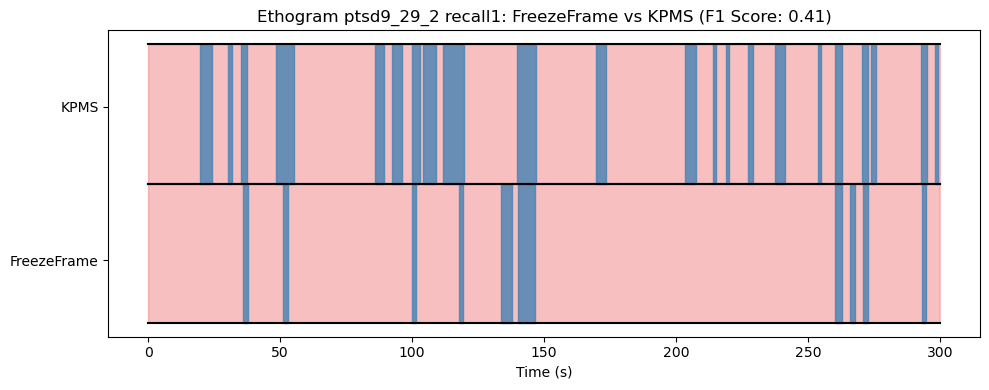

Plotted ethogram for Cohort ID: ptsd9_29_2, Day: recall1, F1 Score: 0.41


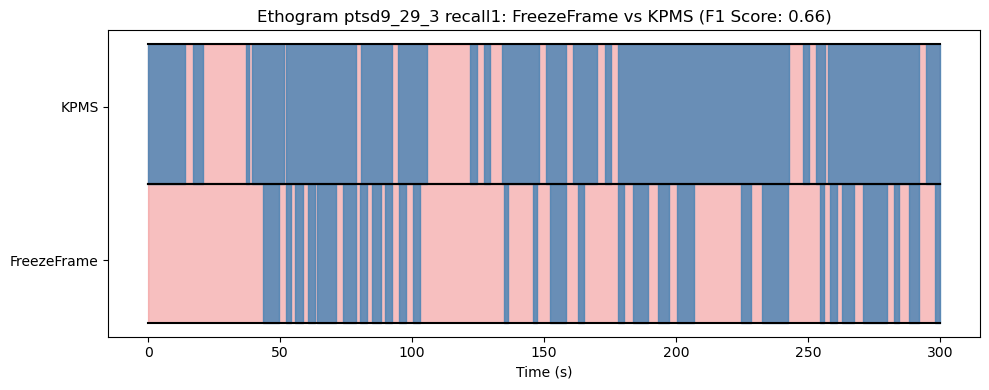

Plotted ethogram for Cohort ID: ptsd9_29_3, Day: recall1, F1 Score: 0.66


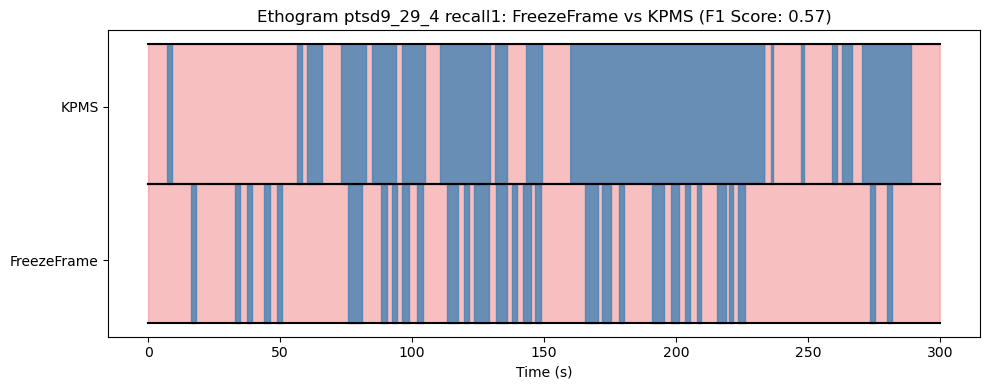

Plotted ethogram for Cohort ID: ptsd9_29_4, Day: recall1, F1 Score: 0.57


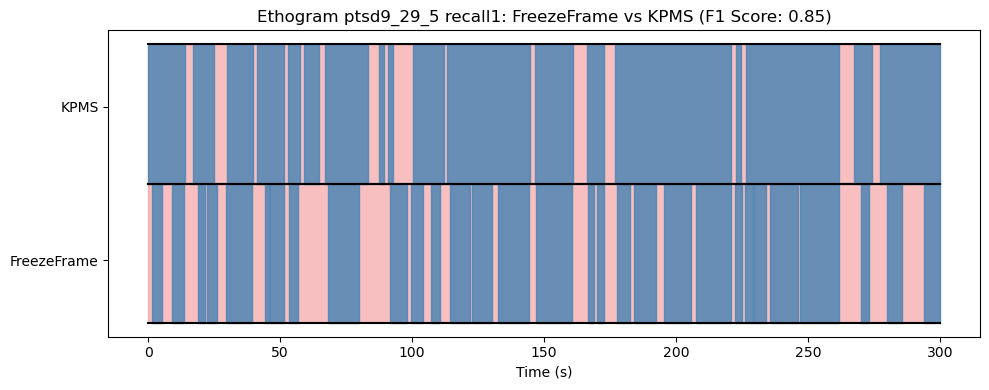

Plotted ethogram for Cohort ID: ptsd9_29_5, Day: recall1, F1 Score: 0.85


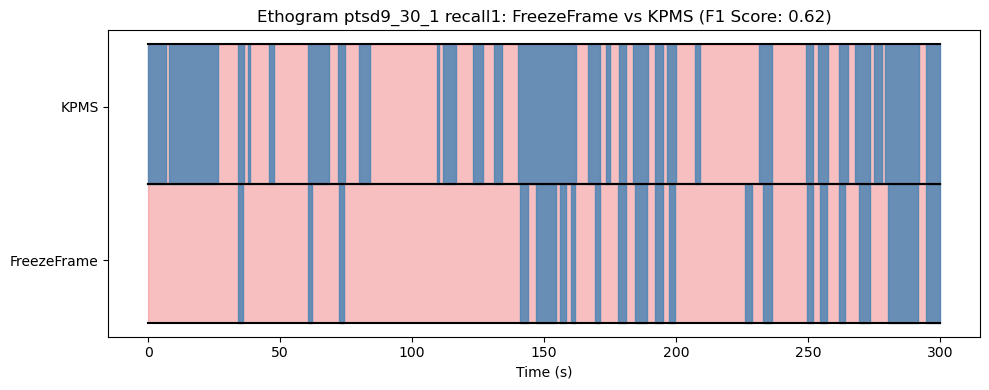

Plotted ethogram for Cohort ID: ptsd9_30_1, Day: recall1, F1 Score: 0.62


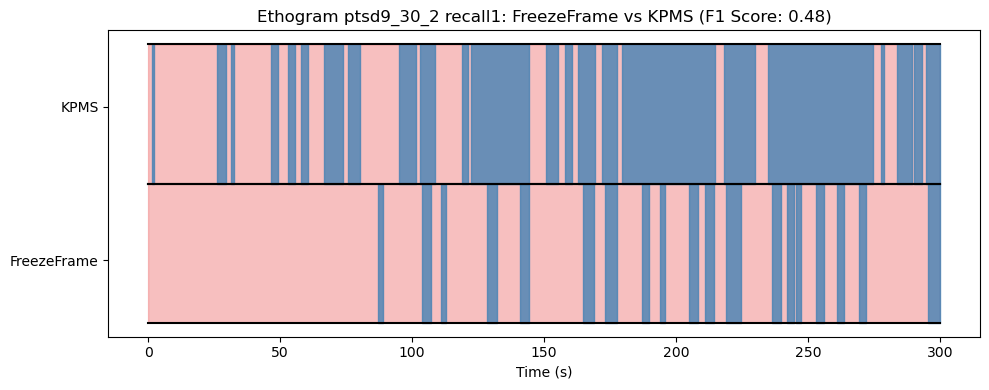

Plotted ethogram for Cohort ID: ptsd9_30_2, Day: recall1, F1 Score: 0.48


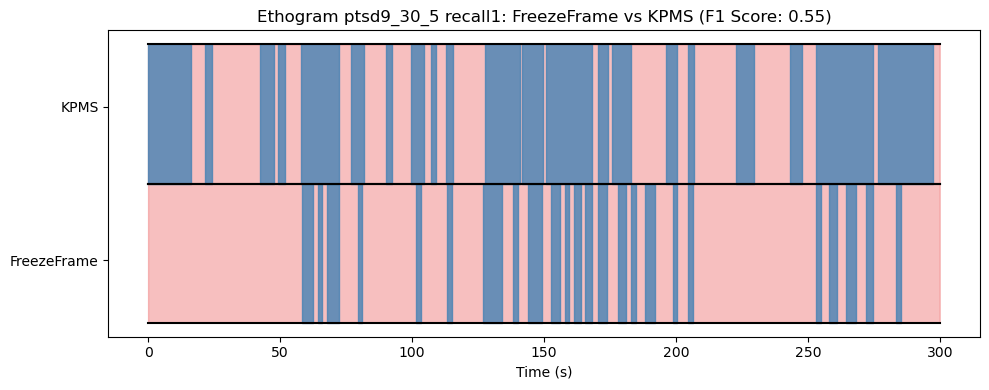

Plotted ethogram for Cohort ID: ptsd9_30_5, Day: recall1, F1 Score: 0.55


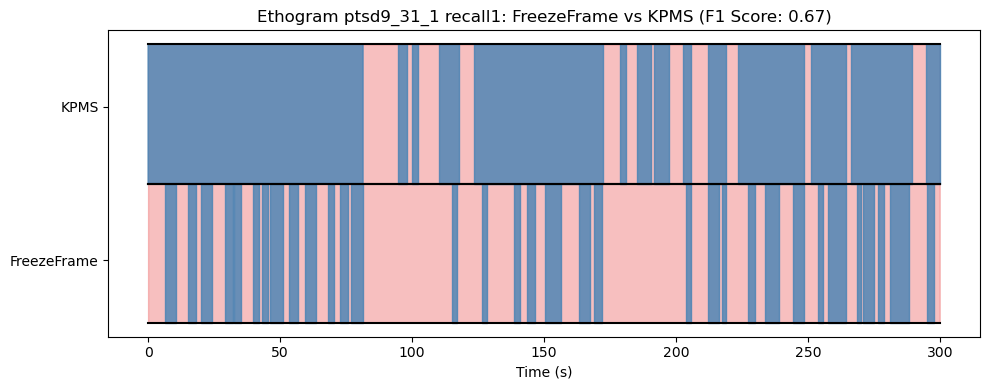

Plotted ethogram for Cohort ID: ptsd9_31_1, Day: recall1, F1 Score: 0.67


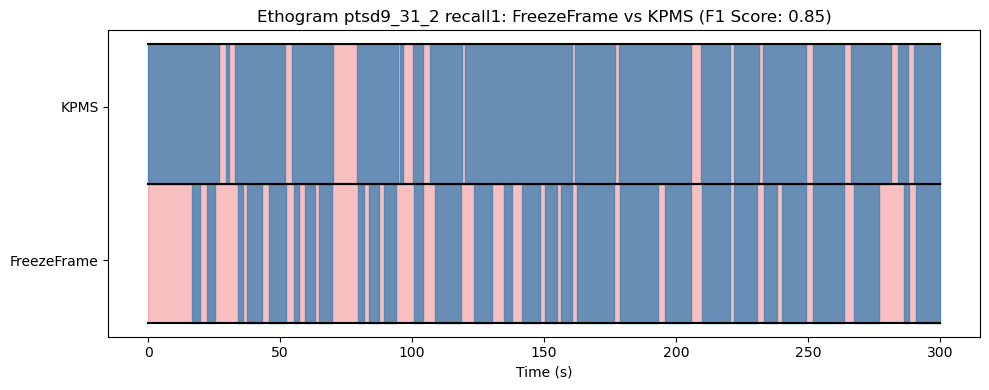

Plotted ethogram for Cohort ID: ptsd9_31_2, Day: recall1, F1 Score: 0.85


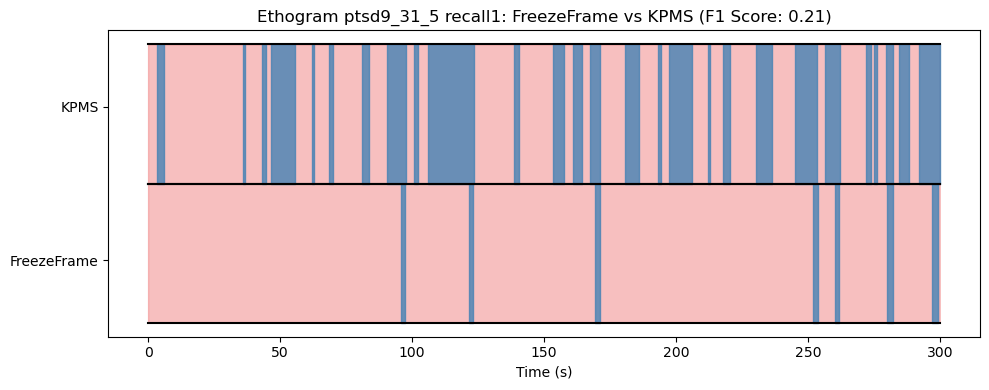

Plotted ethogram for Cohort ID: ptsd9_31_5, Day: recall1, F1 Score: 0.21


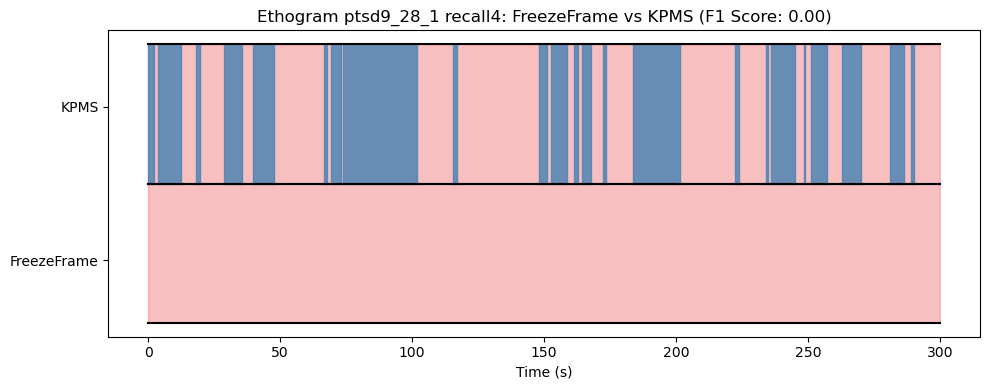

Plotted ethogram for Cohort ID: ptsd9_28_1, Day: recall4, F1 Score: 0.00


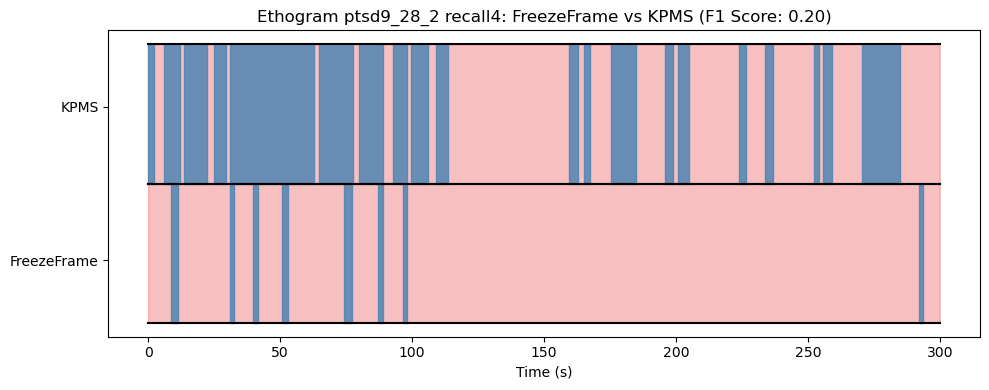

Plotted ethogram for Cohort ID: ptsd9_28_2, Day: recall4, F1 Score: 0.20


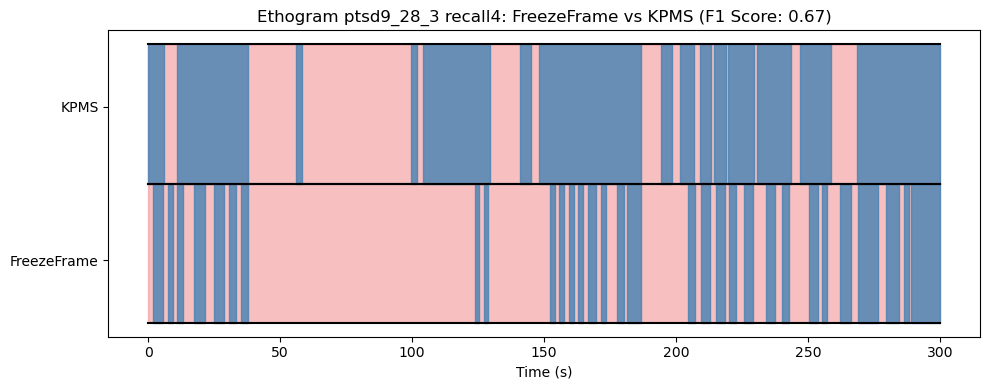

Plotted ethogram for Cohort ID: ptsd9_28_3, Day: recall4, F1 Score: 0.67


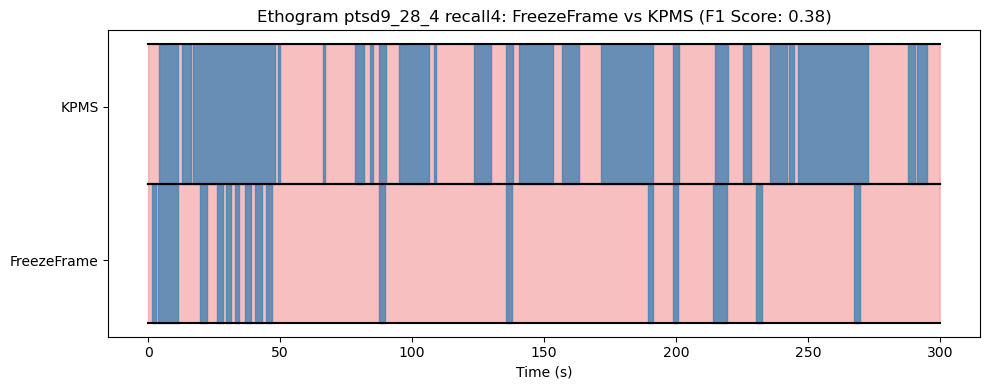

Plotted ethogram for Cohort ID: ptsd9_28_4, Day: recall4, F1 Score: 0.38


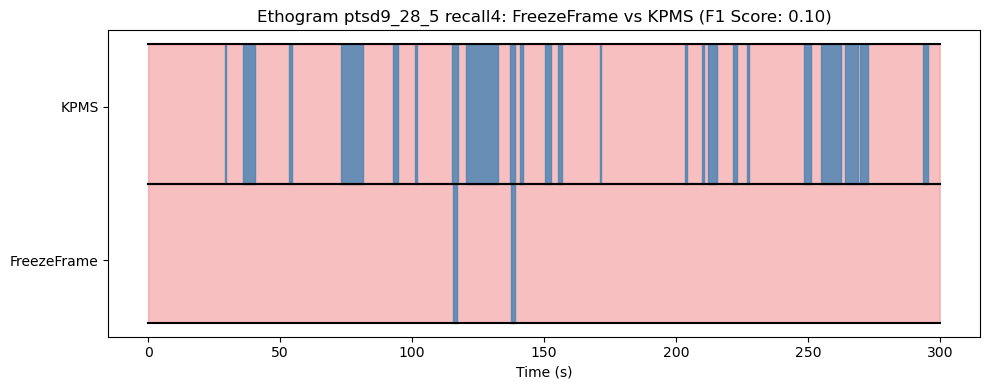

Plotted ethogram for Cohort ID: ptsd9_28_5, Day: recall4, F1 Score: 0.10


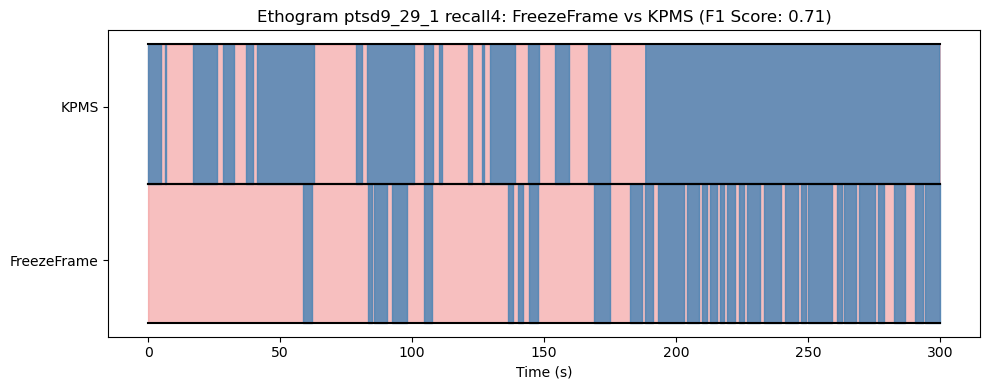

Plotted ethogram for Cohort ID: ptsd9_29_1, Day: recall4, F1 Score: 0.71


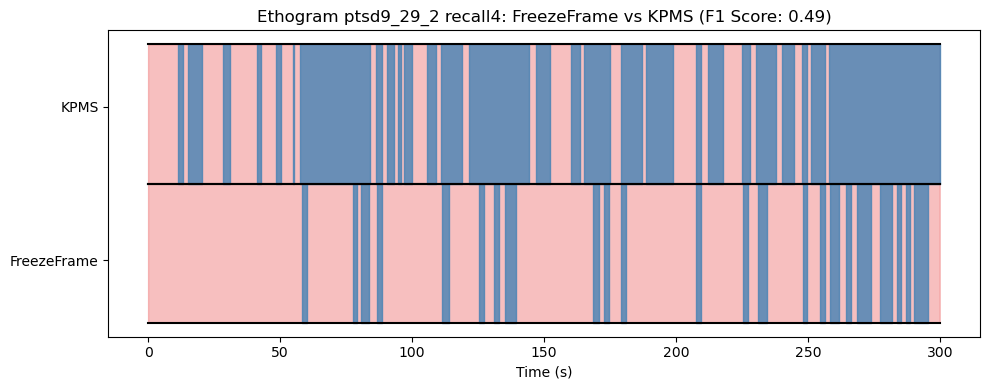

Plotted ethogram for Cohort ID: ptsd9_29_2, Day: recall4, F1 Score: 0.49


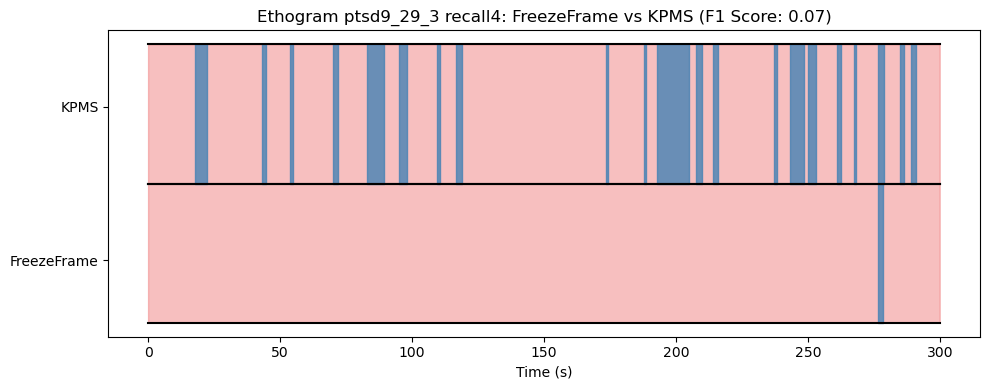

Plotted ethogram for Cohort ID: ptsd9_29_3, Day: recall4, F1 Score: 0.07


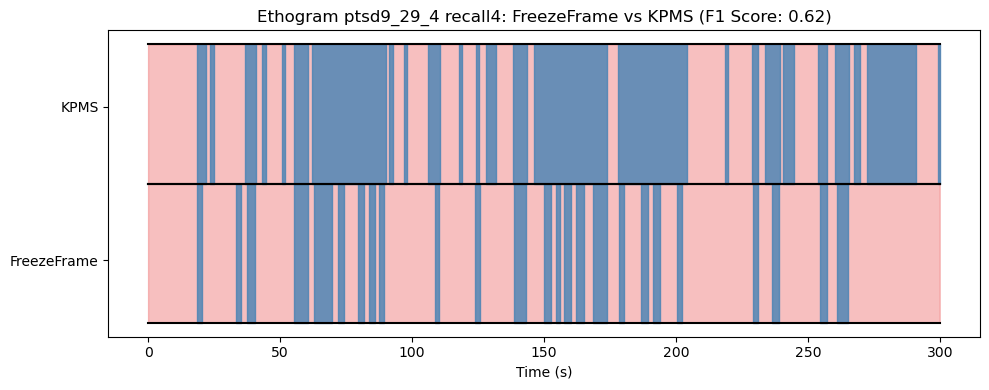

Plotted ethogram for Cohort ID: ptsd9_29_4, Day: recall4, F1 Score: 0.62


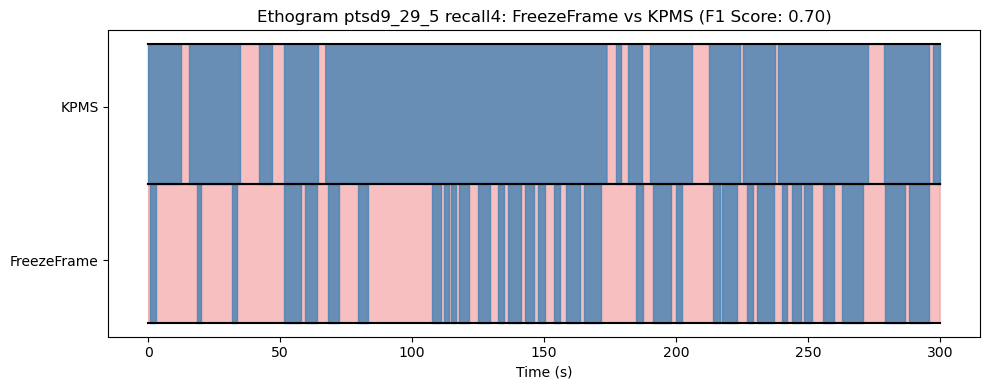

Plotted ethogram for Cohort ID: ptsd9_29_5, Day: recall4, F1 Score: 0.70


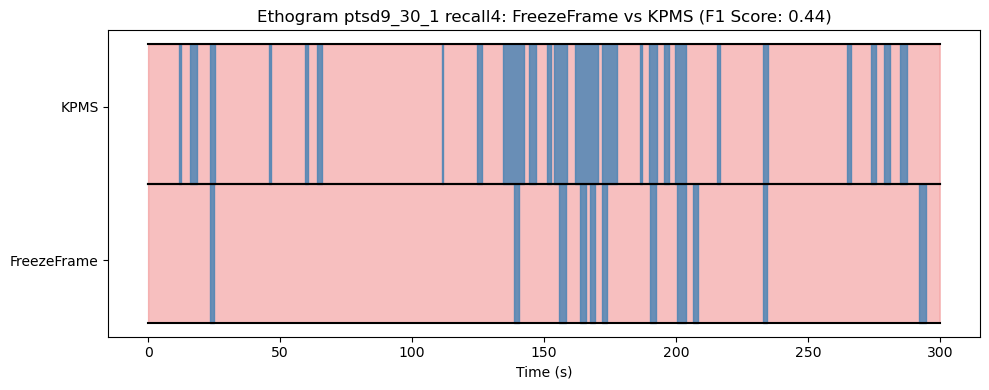

Plotted ethogram for Cohort ID: ptsd9_30_1, Day: recall4, F1 Score: 0.44


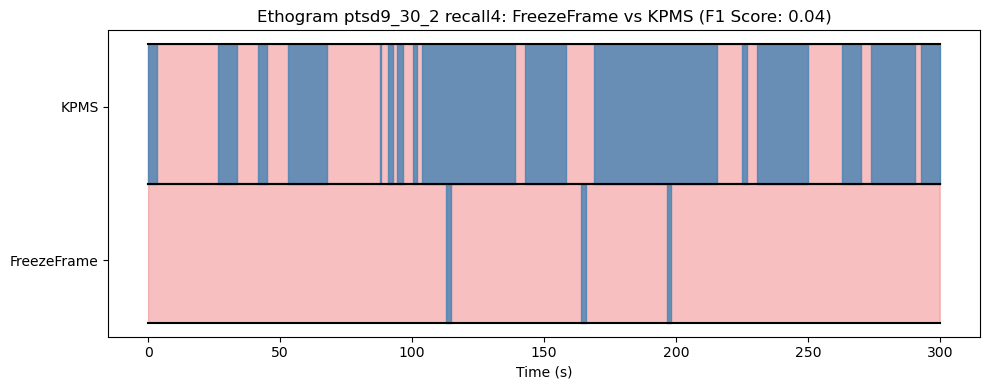

Plotted ethogram for Cohort ID: ptsd9_30_2, Day: recall4, F1 Score: 0.04


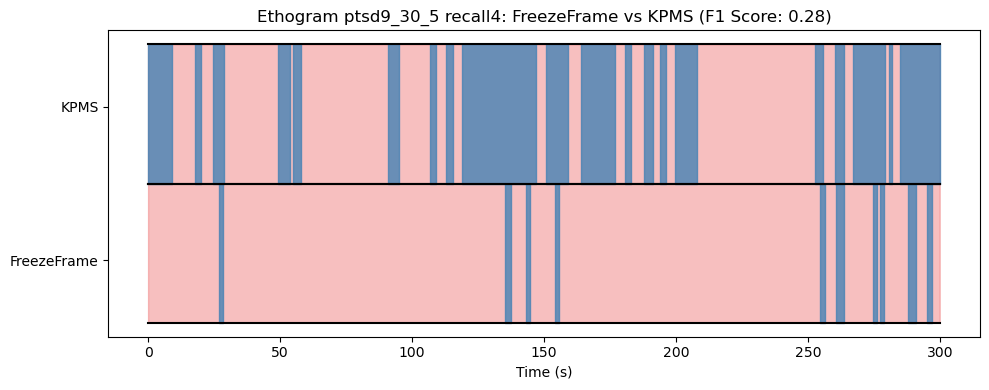

Plotted ethogram for Cohort ID: ptsd9_30_5, Day: recall4, F1 Score: 0.28


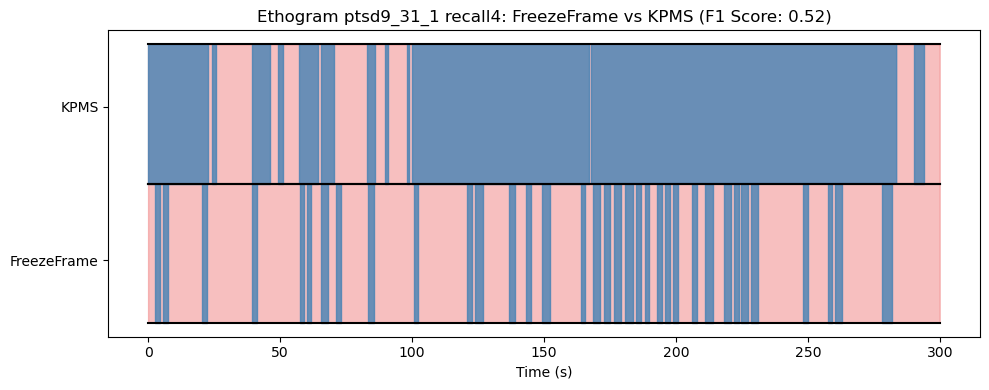

Plotted ethogram for Cohort ID: ptsd9_31_1, Day: recall4, F1 Score: 0.52


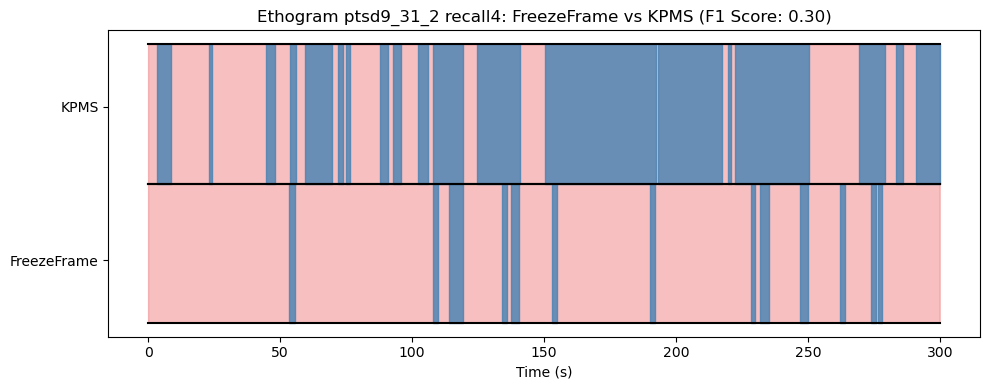

Plotted ethogram for Cohort ID: ptsd9_31_2, Day: recall4, F1 Score: 0.30


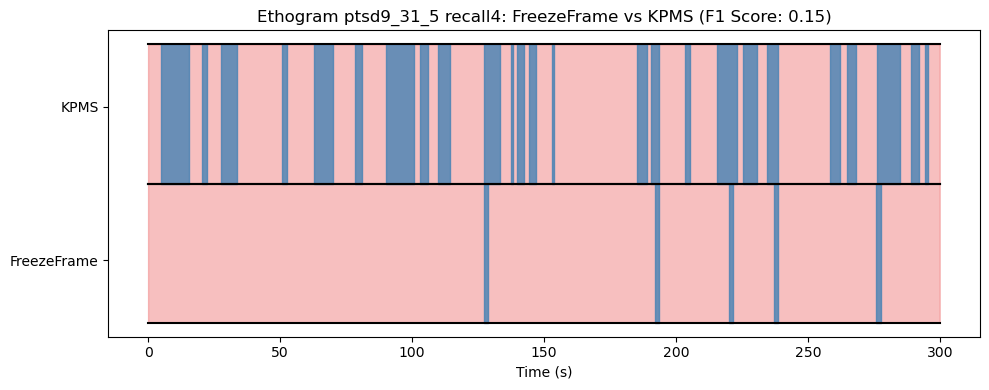

Plotted ethogram for Cohort ID: ptsd9_31_5, Day: recall4, F1 Score: 0.15

F1 Scores Summary:
Total F1 Score: 56.48
Average F1 Score (All): 0.41
Average F1 Score (Sefl): 0.50
Average F1 Score (Control): 0.24


In [173]:
plot_all_ethograms(freeze_frame_175_bouts, moseq_data, plot_freeze_ethogram)



In [174]:
# treatment = ['ptsd6_72', 'ptsd2_83', 'ptsd4_64', 'ptsd3_12', 'ptsd6_75']
# control = ['ptsd2_92', 'ptsd5_81', 'ptsd9_28_4', 'ptsd4_71', 'ptsd4_61']
# moseq_data[['cohort_id', 'day']] = moseq_data['cohort_id'].apply(lambda x: pd.Series(extract_cohort_and_day(x)))
# filtered_moseq_data = moseq_data[moseq_data['cohort_id'].isin(treatment + control)]
# filtered_freeze_frame = freeze_frame_175_bouts[freeze_frame_175_bouts['cohort_id'].isin(treatment + control)]

In [175]:
# moseq_data

In [176]:
# plot_all_ethograms(filtered_freeze_frame, filtered_moseq_data, plot_freeze_ethogram)

In [177]:
# plot_all_ethograms(filtered_freeze_frame, filtered_moseq_data, plot_syllable_ethogram)